### This notebook provides replication and modification of code from Bletery and Nocquet (2023) and Bletery and Nocquet (2024), as discussed in Bradley and Hubbard (2023) and Bradley and Hubbard (2024)

BN23 https://www.science.org/doi/full/10.1126/science.adg2565

BN24 https://eartharxiv.org/repository/view/7222/


BH23a https://earthquakeinsights.substack.com/p/earthquake-precursors-not-so-fast

BH23b https://earthquakeinsights.substack.com/p/update-on-apparent-gps-detection

BH24 https://earthquakeinsights.substack.com/p/...


To run this code, you will need to first follow the instructions at these two separate Zenodo archives provided by Bletery and Nocquet (2023,2024), including installation of various Python packages. The code in this notebook is partially adopted from BN23/BN24, and is partially new code. The code is distributed under a Creative Commons License, as specified at the following Zenodo archives. Please credit the original authors, Bletery and Nocquet (2023, 2024) as appropriate.

https://zenodo.org/records/8064086    Contains data and scripts from BN23

https://zenodo.org/records/11198744   (Version 1 contains important data ZIP files)

https://zenodo.org/records/11371894   (Version 2 contains the updated BN24 scripts)

Please note that the code re-loads and re-calculates stacks differently in different sections. Direct any questions to Kyle Bradley - geokyle[at]gmail.com


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
import scipy.optimize
import pyeq.green.make
import random 
from mpl_toolkits.basemap import Basemap
from scipy.signal import detrend
from pyacs.lib.coordinates import geo_spherical_distance
from datetime import datetime
import math

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Declare variables

nsample = 576
mu=29353000000 # shear modulus
L, W = 1, 1

data_byEQ_dir = 'data_byEQ'
leq_file = glob(data_byEQ_dir+"/20*_MW_*/dot_product_stack.txt")
fig_dir = 'figures'
TO_fig_dir = 'TO_source_test'

# Declare variables
eq_date = []

B = np.genfromtxt('scardec_2000_2024.txt')
# B = np.genfromtxt('scardec_M7_full.txt')

eq_lat, eq_lon, eq_dep, eq_date = B[:,7], B[:,8], B[:,9], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))
nsample = 576
nd = int(nsample/2)
t = np.arange(-48-1/24,0-1/24,1/12)

dist_threshold = 25 # Distance threshold for exclusion of near-field stations (in km)


In [3]:
M = mu * L*1000 * W*1000 
t = [0]*nsample
for i in range(nsample):
    t[i] = -48 * (nsample-1-i)/nsample - 2.5/60 
nd = int(nsample/2)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

if not os.path.exists(TO_fig_dir):
    os.makedirs(TO_fig_dir)

In [4]:
# Define functions to fit sinusoids and exponential functions 

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def func(x, a, b, c):
    return a * np.exp(b * x) + c

In [82]:
# Use the new data loading scheme from BN24 which recalculates the stacks and can exclude stations by distance

eq_stack = np.zeros([len(leq_file),nsample])
used_eqs, used_eq_dirs = [], []
sigmag, sigmags = np.zeros(len(leq_file)), np.zeros(len(leq_file))
k = 0
Inc = 0
Nst = 0
Neq = 0
N = []


for eq_file in leq_file:
    
    eq = eq_file.split('/')[-2]
    print(eq)
    
# Uncomment to exclude the El Mayor-Cucapah earthquake:
#     if eq in ['20100404T22:40:43_MW_7.1']: 
#         continue

# Uncomment to include only a specific set of earthquakes
#     if eq not in ['20100404T22:40:43_MW_7.1','20110311T05:46:24_MW_9.0','20140310T05:18:13_MW_7.0']: 
#         continue
    
# Uncomment to exclude BN24 events and use only BN23 events
#     if int(eq[0:4]) > 2020:
#         continue
        
    # Exclude events with clear foreshock offsets, as in BN23
    if eq in ['20040905T10:07:07_MW_7.2','20040905T14:57:18_MW_7.5','20140403T02:43:13_MW_7.7','20190706T03:19:53_MW_7.0']:
        continue
        
    used_eqs.append(eq)
    
    eq_dir = eq_file.split('/')[0]+'/'+eq
    
    used_eq_dirs.append(eq_dir)
    
    code = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=str,usecols=0))
    nst = code.shape[0] 
    syn_eastn = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics.txt',dtype=float,usecols=0))
    syn_northn = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics.txt',dtype=float,usecols=1))
    st_lon = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=float,usecols=2))
    Tn = np.zeros((code.shape[0],2,576))
    st_dist = []
    I_eq = np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0]
    
    sj2n = np.zeros(nst)
    for i in range(nst):
        ts = np.genfromtxt(eq_file.split('/')[0]+'/'+eq+'/TS_'+code[i]+'.dat')
        east = ts[:,7] - np.median(ts[0:nd,7]) 
        north = ts[:,8] - np.median(ts[0:nd,8])        
        norme, normn = np.linalg.norm(east[0:nd]), np.linalg.norm(north[0:nd])
        sj2n[i] = norme*norme + normn*normn 
        dist_x = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000
        st_dist.append(np.sqrt(dist_x**2+eq_dep[I_eq]**2))
        if np.sqrt(dist_x**2+eq_dep[I_eq]**2)<dist_threshold:
            print('Station longitude: '+str(st_lon[i])+', latitude: '+str(st_lat[i]))
            print('Hypocenter longitude: '+str(eq_lon[I_eq])+', latitude: '+str(eq_lat[I_eq])+', depth: '+str(eq_dep[I_eq]))
            print('Epicenteral distance: '+str(dist_x)+' km')
            plt.figure(figsize=(16, 4), dpi=80)
            plt.title('Time series of the removed station: '+str(code[i]))
            plt.plot(t,east,'.')
            plt.ylabel('East (m)')
            plt.figure(figsize=(16, 4), dpi=80)
            plt.plot(t,north,'.')
            plt.ylabel('North (m)')
            plt.xlabel('Time (h)')
        Tn[i,0,:], Tn[i,1,:] = east, north
        
    In = np.where(np.array(st_dist)<dist_threshold)[0]
    if len(In)>0:
        print(eq+': '+str(len(In))+' station(s) < '+str(dist_threshold)+' km away from the hypocenter removed')
    Inc = len(In)+Inc
    Nst = Nst+nst-len(In)
    N.append(nst)
    T = np.delete(Tn,In,axis=0)
    sj2 = np.delete(sj2n,In)
    syn_east, syn_north = np.delete(syn_eastn,In), np.delete(syn_northn,In)
    normg = np.sqrt(syn_east**2+syn_north**2)
    normgs = np.divide(normg,sj2)
    sigmag[k] = sum(normg)
    sigmags[k] = sum(normgs)
        
    eq_stack[k,:] = np.dot(syn_east/sj2,T[:,0,:]) + np.dot(syn_north/sj2,T[:,1,:])
    Neq=Neq+1
    k = k+1
    
stack = sum(eq_stack)
print('Total: '+str(Inc)+' station(s) removed')
print(str(Neq)+' earthquakes in the stack')
print(str(Nst)+' stations')


20130925T16:42:43_MW_7.0
20110407T14:32:43_MW_7.1
20231207T12:56:30_MW_7.0
20121107T16:35:46_MW_7.3
20071219T09:30:27_MW_7.1
20030925T19:50:06_MW_8.1
20140310T05:18:13_MW_7.0
20150425T06:11:25_MW_7.9
20110624T03:09:39_MW_7.3
20230118T06:06:13_MW_7.1
20171112T18:18:17_MW_7.3
20110102T20:20:17_MW_7.2
20121207T08:18:23_MW_7.2
20230519T02:57:06_MW_7.7
20150512T07:05:19_MW_7.3
20031227T16:00:59_MW_7.2
20230716T06:48:20_MW_7.2
20090715T09:22:29_MW_7.7
20170717T23:34:13_MW_8.0
20110311T05:46:24_MW_9.0
20071114T15:40:50_MW_7.8
20131025T17:10:19_MW_7.1
20141014T03:51:34_MW_7.2
20140419T13:28:00_MW_7.4
20170908T04:49:19_MW_8.1
20140413T12:36:19_MW_7.4
20180216T23:39:39_MW_7.2
20210320T09:09:43_MW_7.1
20100404T22:40:43_MW_7.1
20201019T20:54:38_MW_7.6
20220727T00:43:26_MW_7.0
20050816T02:46:28_MW_7.2
20100103T22:36:25_MW_7.2
20070325T00:40:01_MW_7.1
20120905T14:42:07_MW_7.5
20101225T13:16:37_MW_7.3
20180114T09:18:45_MW_7.1
20181205T04:18:08_MW_7.5
20230206T01:17:35_MW_8.0
20110820T16:55:02_MW_7.0


Using 5063 stations
Squared Green's functions of stations < 200 km counts for 98.4 % of the total


Text(120, 40.94195779090914, '42.9 %')

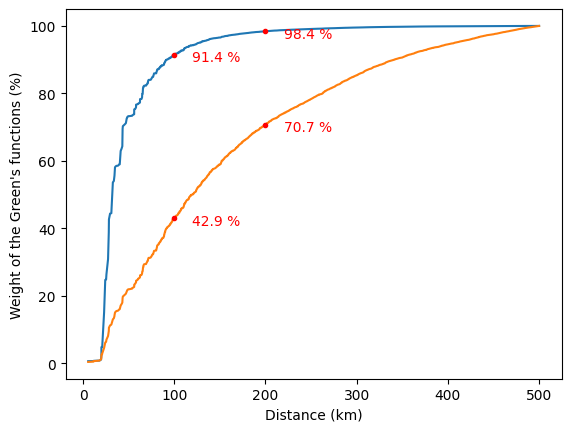

In [83]:
# Make the distance vs GF weight diagram using all stations farther than the distance threshold

sigmag, st_dist, sigmaga = [], [], []
sg_eq = np.zeros([len(used_eqs),1])
j = 0
this_Nst = 0

for eq in used_eqs:
    I_eq = np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0]
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))

    # sqrt(sigmag2) is the length of each Green's function vector at each site
    sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))
    sg, sga = [], []
    # sigmag is the list of all Greens function lengths for all earthquakes
    # st_dist is the list of all station distances for all earthquakes
    for i in range(len(sigmag2)):
        dist=geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000
#         if dist >= dist_threshold:
            
# BN24 simply sum the lengths of the vectors
        sigmaga.append(np.sqrt(sigmag2[i]))
        sga.append(np.sqrt(sigmag2[i]))
# But the dot product of a and a has a length of a squared
        sigmag.append(sigmag2[i])
        sg.append(sigmag2[i])
        st_dist.append(geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000)
        # sg_eq is the sum of the lengths of all Greens functions for this earthquake
        this_Nst = this_Nst+1

    sg_eq[j] = np.sum(sg)
    j = j+1

print('Using {} stations'.format(this_Nst))    
    
I_s = sorted(range(len(st_dist)), key=st_dist.__getitem__)

st_dist_s, sigmag_s, sigmaga_s = [], [], []

for i in range(len(st_dist)):
    # sigmag_s is a list of the lengths of the Greens functions for all earthquakes, sorted by distance from nearest to farthest
    sigmag_s.append(sigmag[I_s[i]])
    sigmaga_s.append(sigmaga[I_s[i]])
    st_dist_s.append(st_dist[I_s[i]])
    
# sgc is the cumulative sum of the sorted Greens functions, by distance
sgc = np.cumsum(sigmag_s)
sgca = np.cumsum(sigmaga_s)
# Normalized to the largest total sum
sgcn = 100*sgc/sgc[-1]
sgcna = 100*sgca/sgca[-1]


v200 = min(st_dist_s, key=lambda x:abs(x-200))
v100 = min(st_dist_s, key=lambda x:abs(x-100))
I200 = np.where(st_dist_s==v200)[0][0]
I100 = np.where(st_dist_s==v100)[0][0]
print('Squared Green\'s functions of stations < 200 km counts for '+str(round(sgcn[I200],1))+' % of the total')

plt.plot(st_dist_s,sgcn)
plt.plot(st_dist_s,sgcna)
plt.plot(200,sgcn[I200],'r.')
plt.plot(200,sgcna[I200],'r.')
plt.plot(100,sgcn[I100],'r.')
plt.plot(100,sgcna[I100],'r.')
plt.xlabel('Distance (km)')
plt.ylabel('Weight of the Green\'s functions (%)')
plt.text(220,sgcn[I200]-2,str(round(sgcn[I200],1))+' %',c='red')
plt.text(220,sgcna[I200]-2,str(round(sgcna[I200],1))+' %',c='red')
plt.text(120,sgcn[I100]-2,str(round(sgcn[I100],1))+' %',c='red')
plt.text(120,sgcna[I100]-2,str(round(sgcna[I100],1))+' %',c='red')


Text(0.5, 1.0, 'Global stack')

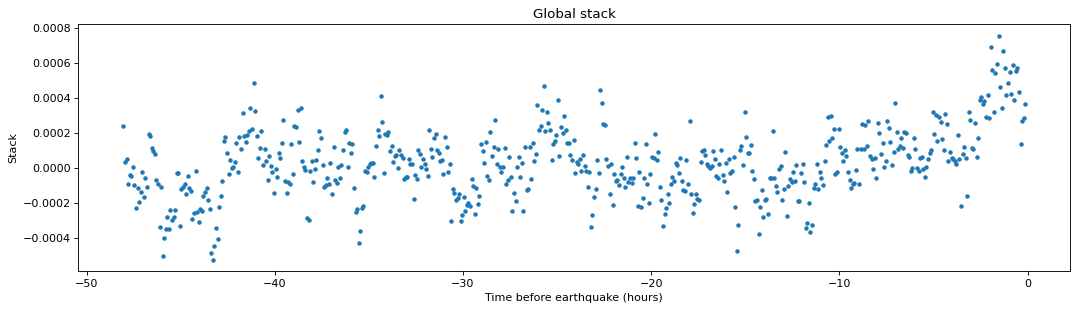

In [84]:
# Plot the global stack (Figure 2.a)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack')

# I=np.where(stack<0)[0][-1]
# tp = t[I]+2.5/60

# print('Last point with negative stack is '+str(round(abs(tp),2))+' hours before origin time')

Text(0, 0.5, 'number of monotonically increasing obs')

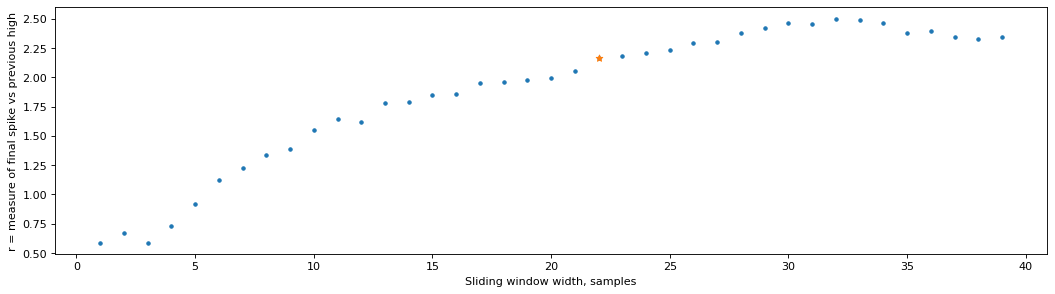

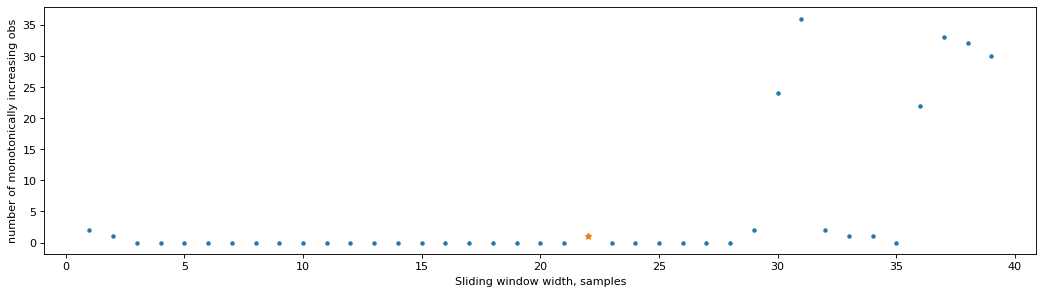

In [8]:

# Plot variation of n, r based on varying window length

test_wd=22

wd_arr, r_arr, n_arr = [], [], []

for i in range(1,40):
    wd=i
    wd_arr.append(float(wd))
    
# wd = window duration of the moving average (in samples)

    Nsma = nsample - wd # number of samples in the moving average time series
    N0 = Nsma - 24 # number of samples of the moving average unaffected by the last 2 hours
    SMA, tsma, Np = [0]*Nsma, [0]*Nsma, [0]*Nsma
    for i in range(Nsma):
        SMA[i] = np.mean(stack[i:i+wd])
        tsma[i] = -48+(i+(1+wd)/2)*5/60

    max_sma = max(SMA[0:N0]) # maximum of the moving average excluding the last 2 hours
    std_sma = np.std(SMA[0:N0]) # standard deviation of the moving average excluding the last 2 hours

    r_arr.append(float(round(SMA[-1]/max_sma,2)))
    n_arr.append(Nsma - np.where(np.diff(SMA)<=0)[0][-1]-2)
#     print('Last point of the moving average is '+str(round(SMA[-1]/max_sma,2))+' times larger than the maximum in the 2 days before')
#     print('Last point of the moving average is '+str(round(SMA[-1]/std_sma,2))+' times larger than the standard deviation')
#     print('The last '+str(Nsma - np.where(np.diff(SMA)<=0)[0][-1]-2)+' points of the moving average are monotonically increasing')

plt.figure(figsize=(16, 4), dpi=80)
plt.scatter(wd_arr, r_arr, marker='.')
plt.scatter(wd_arr[test_wd-1], r_arr[test_wd-1], marker='*')

plt.xlabel('Sliding window width, samples')
plt.ylabel('r = measure of final spike vs previous high')

plt.figure(figsize=(16, 4), dpi=80)
plt.scatter(wd_arr, n_arr, marker='.')
plt.scatter(wd_arr[test_wd-1], n_arr[test_wd-1], marker='*')
plt.xlabel('Sliding window width, samples')
plt.ylabel('number of monotonically increasing obs')


Last point of the moving average is 2.39 times larger than the maximum in the 2 days before
Last point of the moving average is 4.71 times larger than the standard deviation
The last 22 points of the moving average are monotonically increasing


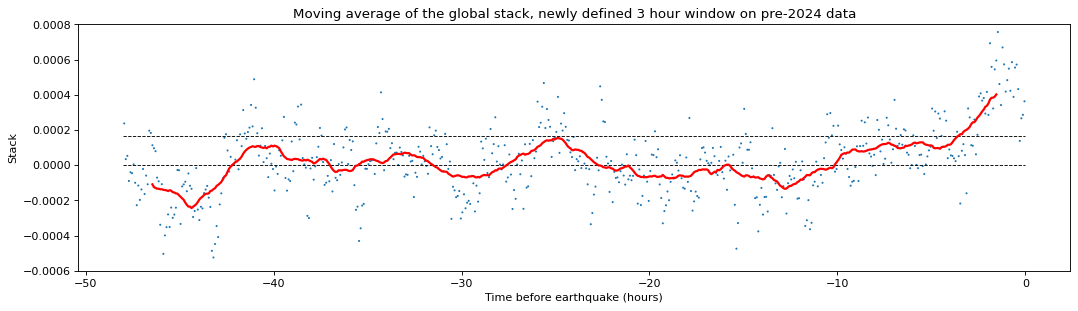

In [9]:
# KEB: Calculate a moving average (windows of 3 hours = 3*60/5 = wd=36) and plot it (as in Figure 2.b)

wd = 36 # window duration of the moving average (in samples)

Nsma = nsample - wd # number of samples in the moving average time series
N0 = Nsma - 24 # number of samples of the moving average unafected by the last 2 hours
SMA, tsma, Np = [0]*Nsma, [0]*Nsma, [0]*Nsma
for i in range(Nsma):
    SMA[i] = np.mean(stack[i:i+wd])
    tsma[i] = -48+(i+(1+wd)/2)*5/60

max_sma = max(SMA[0:N0]) # maximum of the moving average excluding the last 2 hours
std_sma = np.std(SMA[0:N0]) # standard deviation of the moving average excluding the last 2 hours

plt.figure(figsize=(16, 4), dpi=80)
plt.plot([-48,0],[0,0],'k--',linewidth=0.8)
plt.plot([-48,0],[max_sma,max_sma],'k--',linewidth=0.8)
# plt.plot([tp,tp],[min(stack),max(stack)],'k--',linewidth=1)
plt.ylim([-0.0006, 0.0008])
plt.scatter(t,stack,s=[0.7 for n in range(len(t))])
plt.plot(tsma,SMA,'r-',linewidth=2)
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Moving average of the global stack, newly defined 3 hour window on pre-2024 data')

print('Last point of the moving average is '+str(round(SMA[-1]/max_sma,2))+' times larger than the maximum in the 2 days before')
print('Last point of the moving average is '+str(round(SMA[-1]/std_sma,2))+' times larger than the standard deviation')
print('The last '+str(Nsma - np.where(np.diff(SMA)<=0)[0][-1]-2)+' points of the moving average are monotonically increasing')

In [10]:
# These parameters control the following three cells.

dist_cutoff = 200       # Cutoff distance if not using a percentile cutoff (based on number of stations)
use_median = True        # Set to True to use a percentile cutoff (overrides dist_cutoff)
dtcm_pct=50              # The percentile to use. 

# A list of earthquakes to process
selected_eqs = ['20100404T22:40:43_MW_7.1']

# Uncomment and change to exclude specific earthquakes
events_to_exclude=[]
# events_to_exclude=['20210320T09:09:43_MW_7.1', '20100404T22:40:43_MW_7.1', '20240101T07:10:09_MW_7.6']



20100404T22:40:43_MW_7.1 d=318.0km N=236
original stack 1.9132698579710146e-08 stack after removal of far-field mean: 1.8892849881416854e-08
Preservation ratio: 98.746393786041%


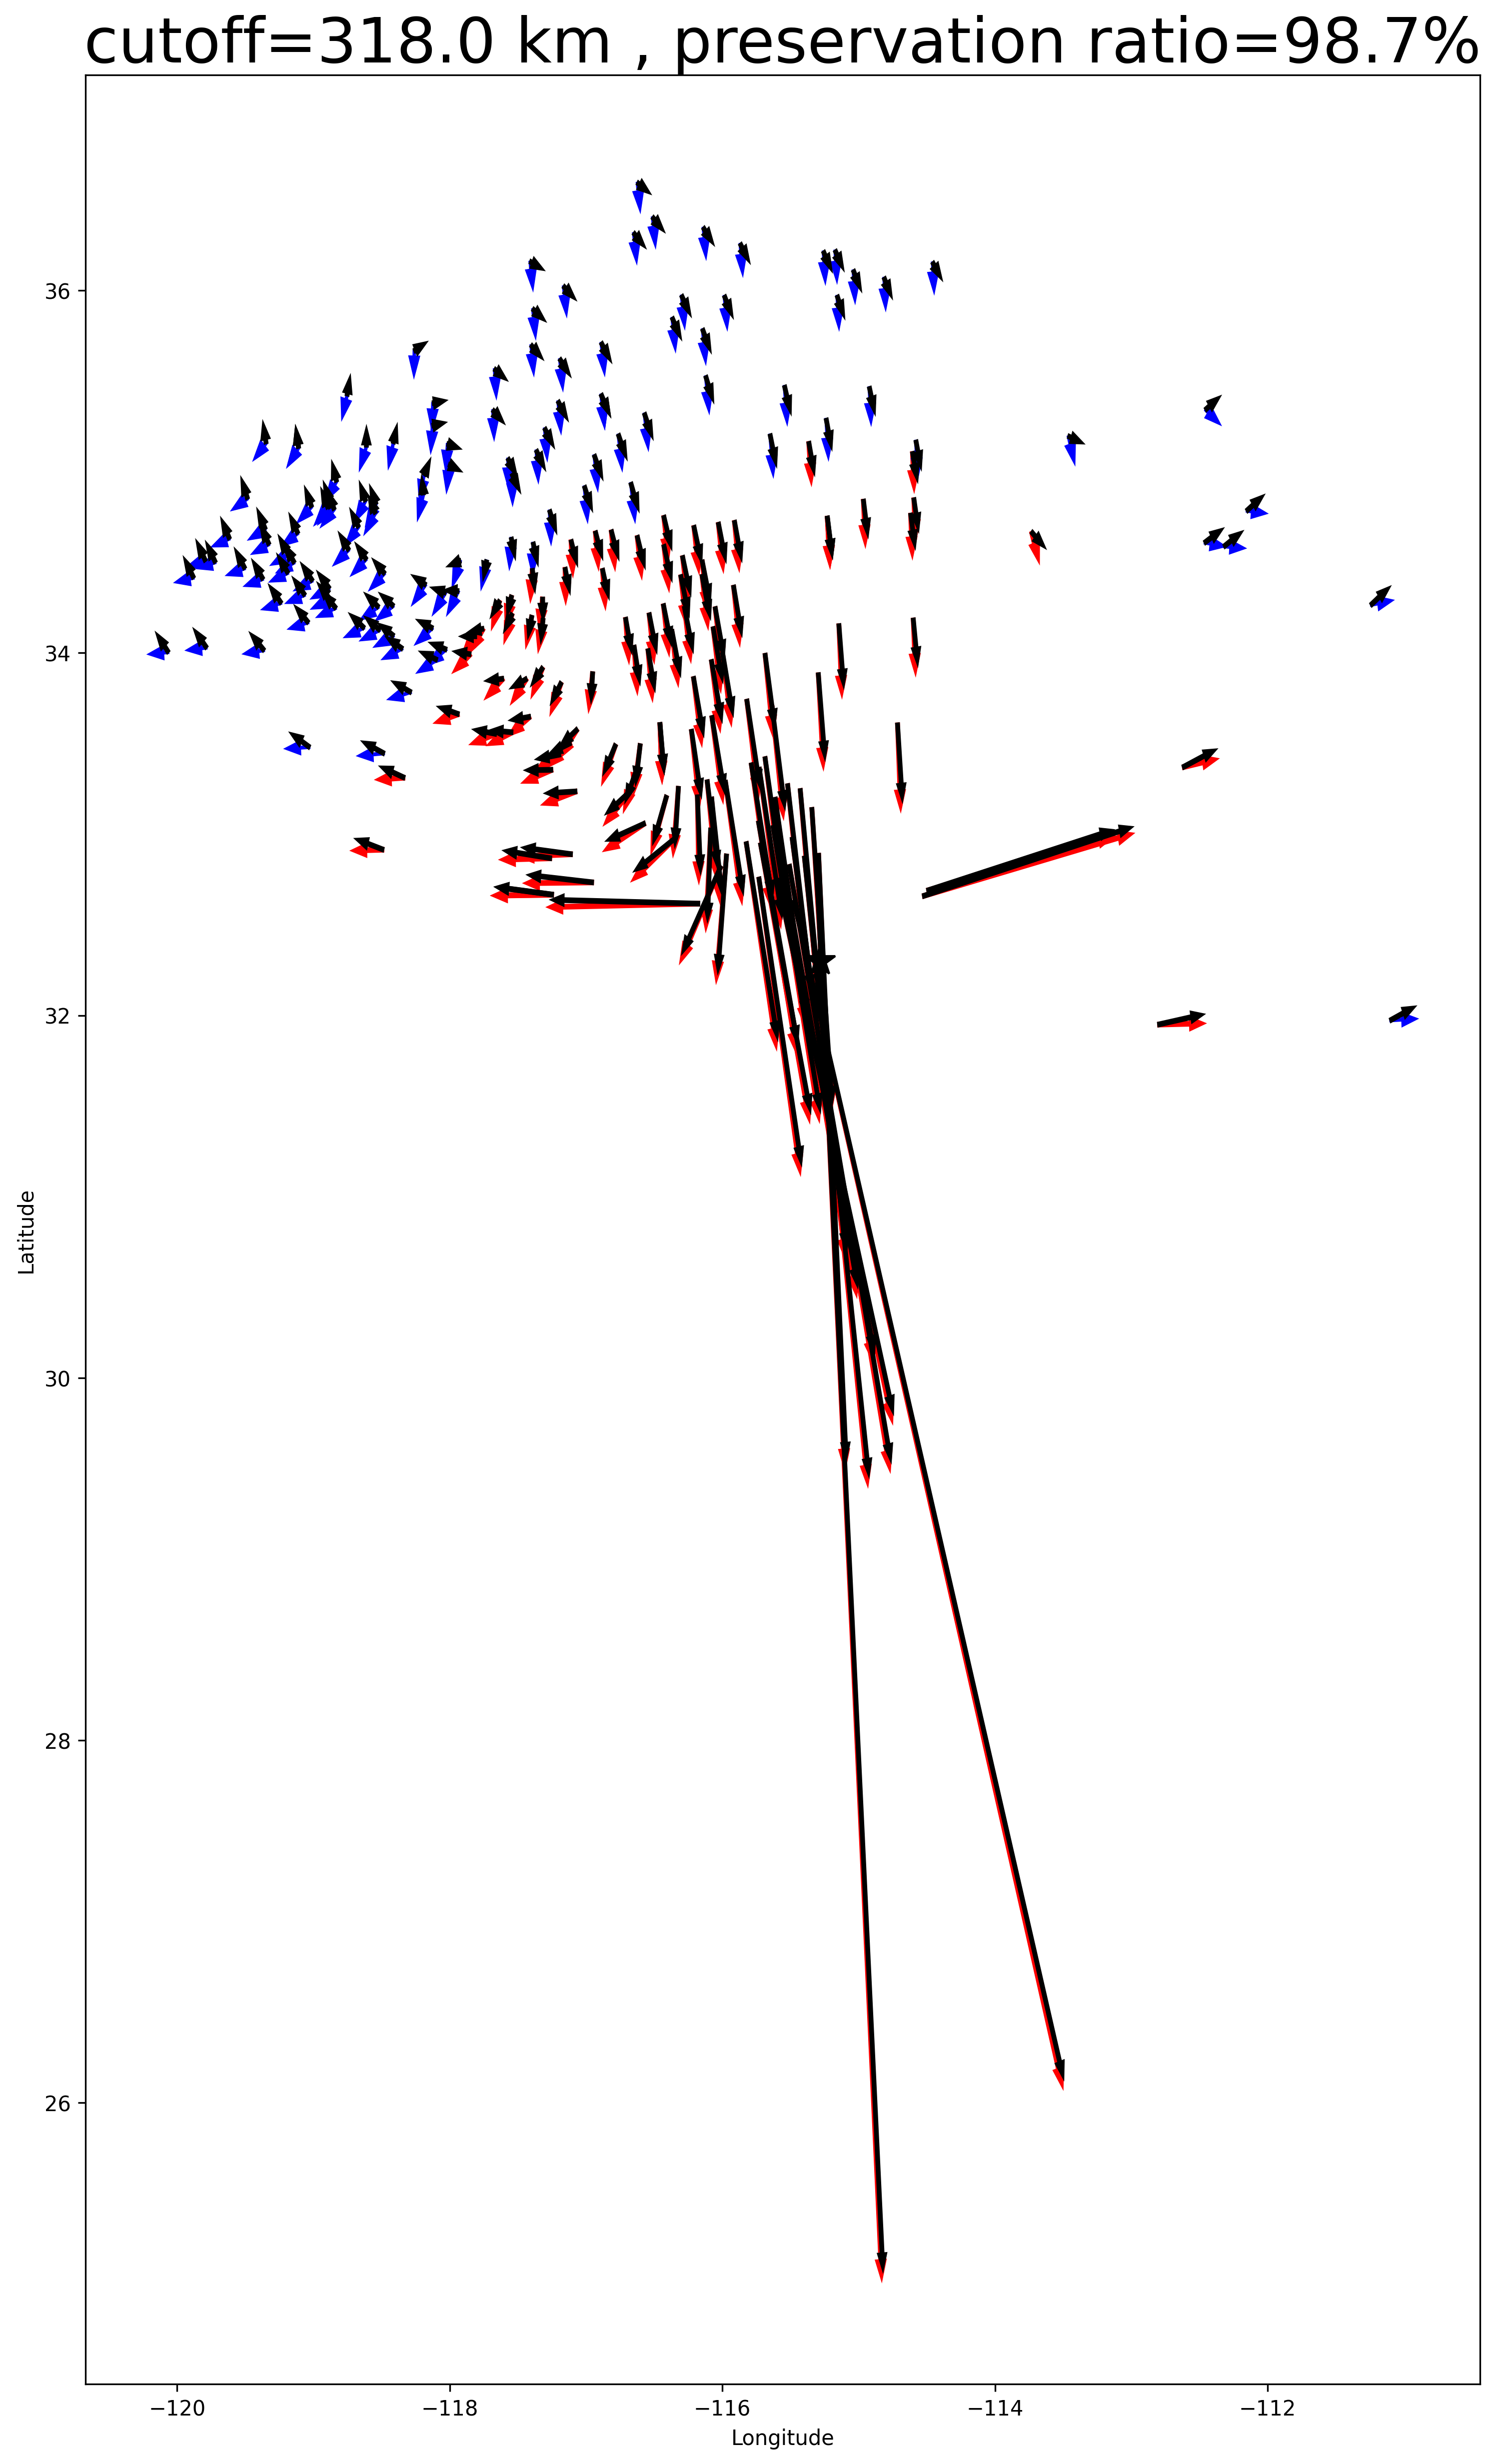

In [ ]:
# KEB: Create a plot for a specific earthquake, showing the synthetic offsets and the effect of subtraction
#      of a far-field mean vector.         

B = np.genfromtxt('scardec_2000_2024.txt')
eq_lat, eq_lon, eq_date = B[:,7], B[:,8], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))
    
a, b = 1E5, 1E2 # ad-hoc scaling factors for plotting

Dvals , cvals = [], []

for eq in used_eqs:
    
    if eq not in selected_eqs:
        continue

    st_dist = []
    syn_east_far = []
    syn_north_far = []
    syn_east_close = []
    syn_north_close = []
    syn_close_lon = []
    syn_close_lat = []
    syn_far_lon = []
    syn_far_lat = []
         
    I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])
    
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    
    if len(np_code) < 20:
        print('Too few sites to proceed (N should be >= 20)')
        continue
        
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))

    i = 0
    for code in np_code:
        st_dist.append(geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000)
 
        i = i+1

    if use_median:
        dist_cutoff=np.ceil(np.percentile(st_dist, dtcm_pct))
    

    for i in range(len(np_code)):
        if st_dist[i] <= dist_cutoff:
            syn_east_close.append(syn_east[i])
            syn_north_close.append(syn_north[i])
            syn_close_lat.append(st_lat[i])
            syn_close_lon.append(st_lon[i])
        else:
            syn_east_far.append(syn_east[i])
            syn_north_far.append(syn_north[i]) 
            syn_far_lat.append(st_lat[i])
            syn_far_lon.append(st_lon[i])

    fig = plt.figure(figsize=(12,20), dpi=300)

    plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*k',markersize=15)
#     plt.arrow(-118,26,10*b*1E-3,0,width = 0.01,color='blue')
#     plt.text(-118,26,'1 cm')

    stack_orig = 0
    stack_close = 0
    stack_far = 0
    dx = 0
    dy = 0

    if len(syn_close_lat) > 0:
        for i in range(len(syn_close_lat)):
            plt.arrow(syn_close_lon[i],syn_close_lat[i],syn_east_close[i]*a,syn_north_close[i]*a,width = 0.02,color='red', head_width=0.07)
            stack_close=stack_close+np.linalg.norm([syn_east_close[i], syn_north_close[i]])
#         plt.arrow(137,42.2,np.mean(syn_east_close)*a, np.mean(syn_north_close)*a, width=0.02, color='red', head_width=0.07)


    if len(syn_far_lat) > 0:
        for i in range(len(syn_far_lat)):
            plt.arrow(syn_far_lon[i],syn_far_lat[i],syn_east_far[i]*a,syn_north_far[i]*a,width = 0.01,color='blue', head_width=0.07)
            stack_far=stack_far+np.linalg.norm([syn_east_far[i], syn_north_far[i]])
        dx=np.mean(syn_east_far)
        dy=np.mean(syn_north_far)
#         plt.arrow(137,42,np.mean(syn_east_far)*a, np.mean(syn_north_far)*a, width=0.02, color='blue', head_width=0.07)
#         plt.arrow(137,42.6,np.mean(syn_east-dx)*a, np.mean(syn_north-dy)*a, width=0.02, color='black')

    for i in range(len(syn_east)):
        # The synthetic displacement vector
        vector_a = [syn_east[i], syn_north[i]]
        # The data vector
        vector_o = [syn_east[i], syn_north[i]]
        stack_orig = stack_orig + np.dot(vector_a, vector_o) 

    # Subtract the far-field average
    ccc_e=syn_east-dx
    ccc_n=syn_north-dy

    # Plot the original vectors minus the average of the far-field vectors
    for i in range(len(st_lat)):
        plt.arrow(st_lon[i],st_lat[i],(syn_east[i]-dx)*a,(syn_north[i]-dy)*a,width = 0.02,color='black')

    # Plot the component in the direction of the original vectors
    syn_cor_east = []
    syn_cor_north = []
    stack_cor=0
    

    # Stack  against the original Greens functions
    for i in range(len(st_lat)):
        # synthetic vector
        vector_a = [syn_east[i], syn_north[i]]
        # data vector
        vector_o = [syn_east[i]-dx, syn_north[i]-dy]
        stack_cor = stack_cor + np.dot(vector_a, vector_o)
        
#     plt.arrow(137,42.4,np.mean(syn_east)*a, np.mean(syn_north)*a, width=0.02, color='purple')
#     plt.text(137.5,41.95,'mean (far)', color='blue', fontsize=20)
#     plt.text(137.5,42.15,'mean (near)', color='red', fontsize=20)
#     plt.text(137.5,42.35,'mean (all)', color='purple', fontsize=20)
#     plt.text(137.5,42.55,'mean (cor)', color='black', fontsize=20)
   
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.title('cutoff={} km , preservation ratio={}%'.format(dist_cutoff, round(stack_cor / stack_orig * 100,1)), fontsize=30)

    
    Dvals.append(len(np_code))
    cvals.append(stack_cor / stack_orig * 100)
    print(eq + ' d=' + str(dist_cutoff) + 'km N=' + str(len(np_code)))
    print('original stack', stack_orig, 'stack after removal of far-field mean:', stack_cor)
    print('Preservation ratio: ' + str(stack_cor / stack_orig * 100) + '%')

# plt.arrow(142.3,35,10*b*1E-3,0,width = 0.02,color='blue')
# plt.text(142.4,35.1,'1 cm')



20130925T16:42:43_MW_7.0: Too few sites (N<20)
20110407T14:32:43_MW_7.1 d=300.0km N=350 Preservation ratio: 99.08671192017206%
20231207T12:56:30_MW_7.0: Too few sites (N<20)
20121107T16:35:46_MW_7.3: Too few sites (N<20)
20071219T09:30:27_MW_7.1: Too few sites (N<20)
20030925T19:50:06_MW_8.1: Too few sites (N<20)
20140310T05:18:13_MW_7.0 d=360.0km N=246 Preservation ratio: 97.04694160428767%
20150425T06:11:25_MW_7.9 d=212.0km N=22 Preservation ratio: 100.16299306121638%
20110624T03:09:39_MW_7.3: Too few sites (N<20)
20230118T06:06:13_MW_7.1: Too few sites (N<20)
20171112T18:18:17_MW_7.3: Too few sites (N<20)
20110102T20:20:17_MW_7.2 d=286.0km N=26 Preservation ratio: 91.41146044187842%
20121207T08:18:23_MW_7.2 d=393.0km N=277 Preservation ratio: 55.62660076333531%
20230519T02:57:06_MW_7.7: Too few sites (N<20)
20150512T07:05:19_MW_7.3: Too few sites (N<20)
20031227T16:00:59_MW_7.2: Too few sites (N<20)
20230716T06:48:20_MW_7.2: Too few sites (N<20)
20090715T09:22:29_MW_7.7: Too few sit

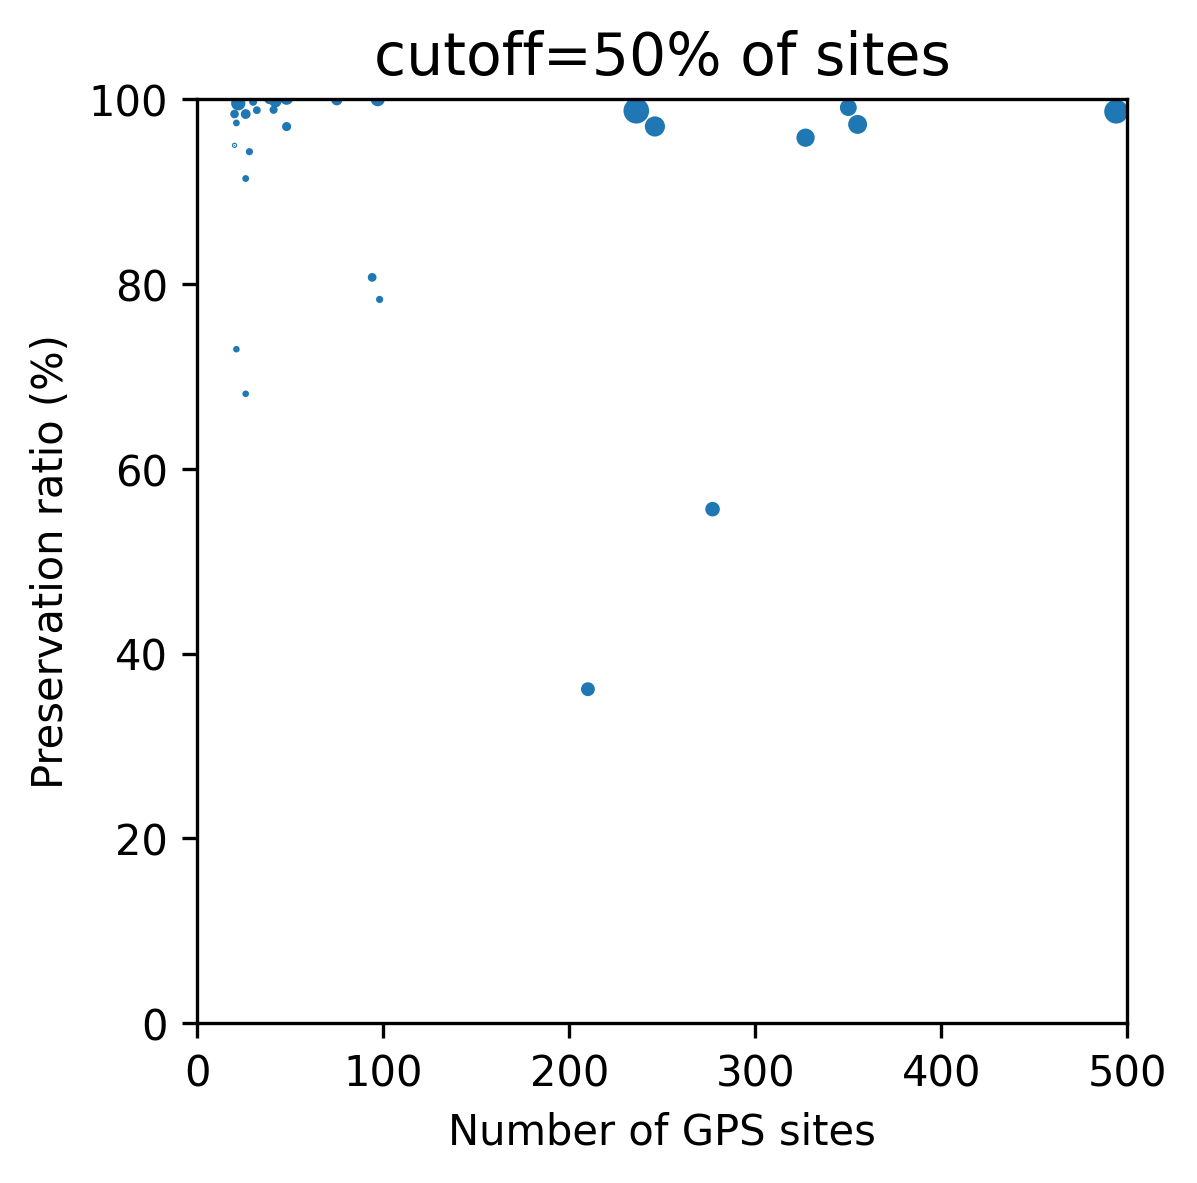

In [12]:
# Calculate preservation ratios for all earthquakes

B = np.genfromtxt('scardec_2000_2024.txt')
eq_lat, eq_lon, eq_date = B[:,7], B[:,8], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))


Dvals , cvals = [], []
sg1 = []
sg2 = []


for eq in used_eqs:

    st_dist = []
    syn_east_far = []
    syn_north_far = []
    syn_east_close = []
    syn_north_close = []
    syn_close_lon = []
    syn_close_lat = []
    syn_far_lon = []
    syn_far_lat = []
        
    I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])
    
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))

    if len(np_code) < 20:
        print(eq + ': Too few sites (N<20)')
        continue
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
    sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))
    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    
    if len(sigmag2)>1:
        sg1.append(sum(np.divide(np.sqrt(sigmag2),sigmaj2)))   
        sg2.append(sum(np.divide(sigmag2,sigmaj2)))
    else:
        sg1.append(float(np.divide(np.sqrt(sigmag2),sigmaj2)))
        sg2.append(float(np.divide(sigmag2,sigmaj2)))
    
    obs_east, obs_north, i = [], [], 0
    for code in np_code:
        ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code+'.dat')
        st_dist.append(geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000)
        i = i+1

    if use_median:
        dist_cutoff=np.ceil(np.percentile(st_dist, dtcm_pct))    
        
    for i in range(len(np_code)):
        if st_dist[i] <= dist_cutoff:
            syn_east_close.append(syn_east[i])
            syn_north_close.append(syn_north[i])
            syn_close_lat.append(st_lat[i])
            syn_close_lon.append(st_lon[i])
        else:
            syn_east_far.append(syn_east[i])
            syn_north_far.append(syn_north[i]) 
            syn_far_lat.append(st_lat[i])
            syn_far_lon.append(st_lon[i])

            
    stack_orig = 0
    stack_close = 0
    stack_far = 0
    dx = 0
    dy = 0

    if len(syn_close_lat) > 0:
        for i in range(len(syn_close_lat)):
            stack_close=stack_close+np.linalg.norm([syn_east_close[i], syn_north_close[i]])

    if len(syn_far_lat) > 0:
        for i in range(len(syn_far_lat)):
            stack_far=stack_far+np.linalg.norm([syn_east_far[i], syn_north_far[i]])
        dx=np.mean(syn_east_far)
        dy=np.mean(syn_north_far)

    for i in range(len(syn_east)):
        stack_orig = stack_orig + np.dot([syn_east[i], syn_north[i]],[syn_east[i], syn_north[i]])

    ccc_e=syn_east-dx,
    ccc_n=syn_north-dy

    # Plot the component in the direction of the original vectors
    syn_cor_east = []
    syn_cor_north = []
    stack_cor=0    

    # Stack  against the original Greens functions
    for i in range(len(st_lat)):
        vector_a = [syn_east[i], syn_north[i]]
        vector_o = [syn_east[i]-dx, syn_north[i]-dy]
        stack_cor = stack_cor + np.dot(vector_a, vector_o)

            
    Dvals.append(len(np_code))
    cvals.append(stack_cor / stack_orig * 100)
    
    # Stack the original synthetic
    print(eq + ' d=' + str(dist_cutoff) + 'km N=' + str(len(np_code)) + ' Preservation ratio: ' + str(stack_cor / stack_orig * 100) + '%')

fig2 = plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(Dvals, cvals, s=800*np.array(sg1))
plt.xlabel('Number of GPS sites')
plt.ylabel('Preservation ratio (%)')
plt.xlim([0,500])
plt.ylim([0,100])


if use_median:
     plt.title('cutoff={}% of sites'.format(dtcm_pct), fontsize=14)
else:
     plt.title('cutoff={}km'.format(dist_cutoff), fontsize=14)


20130925T16:42:43_MW_7.0: Too few sites (N>20 required)
20110407T14:32:43_MW_7.1: Near=176 Far=174
20231207T12:56:30_MW_7.0: Too few sites (N>20 required)
20121107T16:35:46_MW_7.3: Too few sites (N>20 required)
20071219T09:30:27_MW_7.1: Too few sites (N>20 required)
20030925T19:50:06_MW_8.1: Too few sites (N>20 required)
20140310T05:18:13_MW_7.0: Near=123 Far=123
20150425T06:11:25_MW_7.9: Near=11 Far=11
20110624T03:09:39_MW_7.3: Too few sites (N>20 required)
20230118T06:06:13_MW_7.1: Too few sites (N>20 required)
20171112T18:18:17_MW_7.3: Too few sites (N>20 required)
20110102T20:20:17_MW_7.2: Near=13 Far=13
20121207T08:18:23_MW_7.2: Near=142 Far=135
20230519T02:57:06_MW_7.7: Too few sites (N>20 required)
20150512T07:05:19_MW_7.3: Too few sites (N>20 required)
20031227T16:00:59_MW_7.2: Too few sites (N>20 required)
20230716T06:48:20_MW_7.2: Too few sites (N>20 required)
20090715T09:22:29_MW_7.7: Too few sites (N>20 required)
20170717T23:34:13_MW_8.0: Too few sites (N>20 required)
20110

(-0.0008, 0.0008)

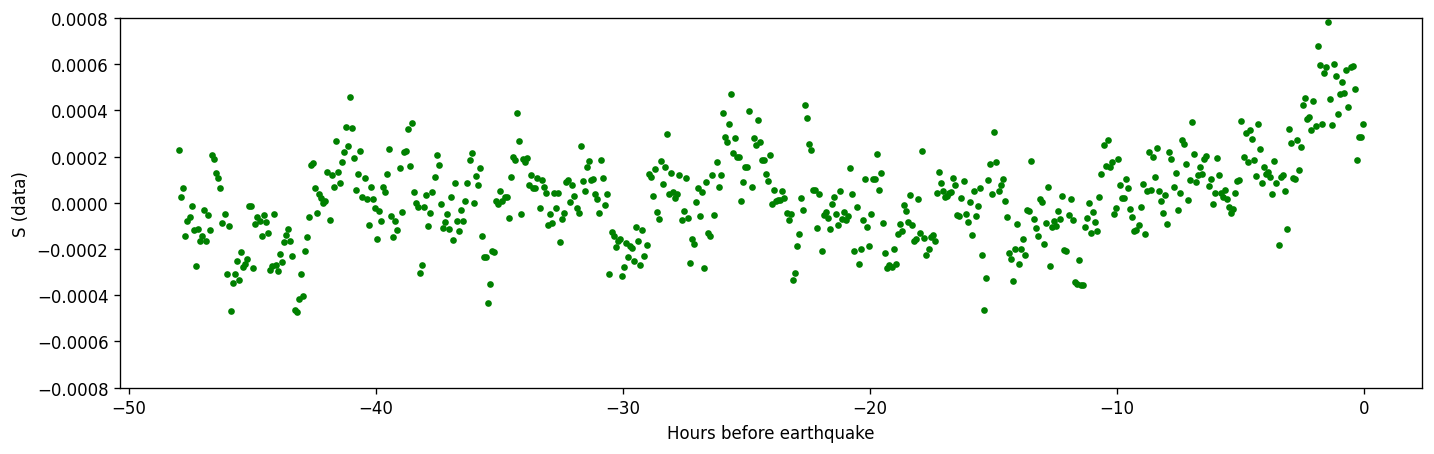

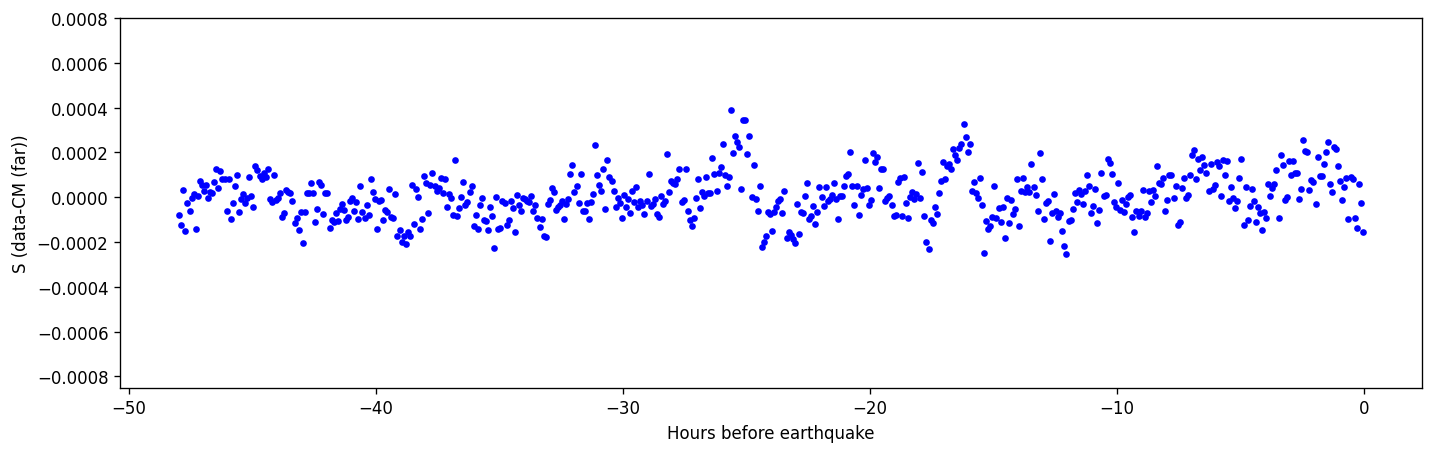

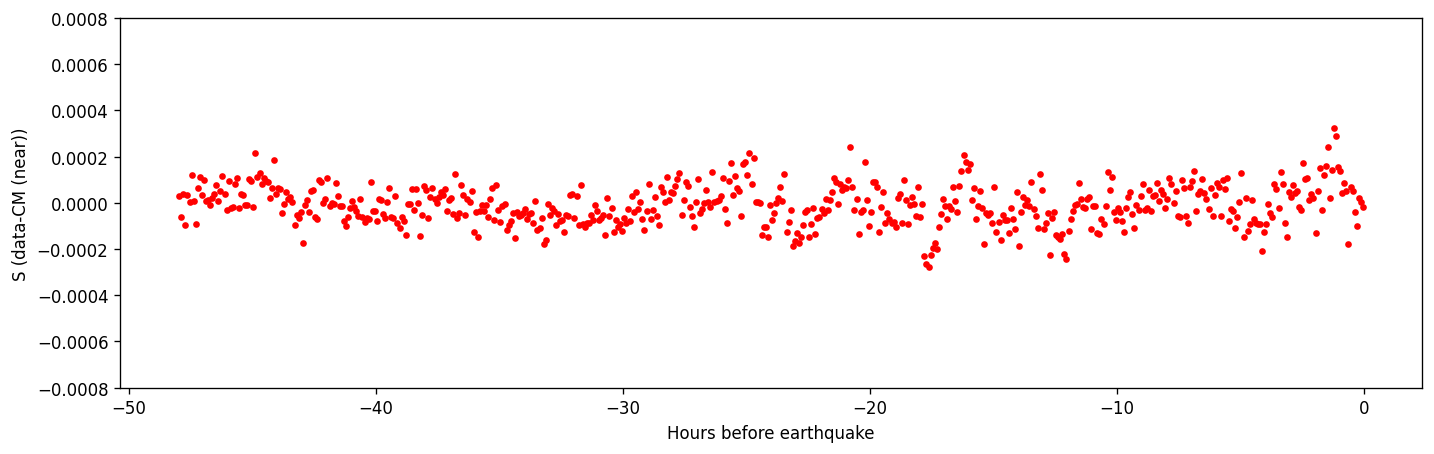

In [13]:
# Re-make the global stack after common mode removal

stacked_eq_dir = []
eq_stack, eq_stack_E, eq_stack_N, Nst, sg1, sg2, eq_dir  = [], [], [], [], [], [], []
Ns = []

# Read the list of possible earthquakes and focal mechanism parameters from scardec file
B = np.genfromtxt('scardec_2000_2024.txt')
eq_lat, eq_lon, eq_dep, eq_date = B[:,7], B[:,8], B[:,9], []
for i in range(len(B)):
    eq_date.append(datetime(int(B[i,1]),int(B[i,2]),int(B[i,3]),int(B[i,4]),int(B[i,5])))
    
eq_stack_o_global, eq_stack_global, eq_stack_near_global, eq_stack_cm_global = np.zeros((nsample)), np.zeros((nsample)), np.zeros((nsample)), np.zeros((nsample))

# Calculate the time in hours for each 5 minute sample (x-axis coordinate)
t = [0]*nsample
for i in range(nsample):
    t[i] = -48 * (nsample-1-i)/nsample - 2.5/60 

n_cutoff=0

# Keep or remove the top N Green functions by length, per earthquake
topn_pct = 5
remove_dominant_synth = False
keep_dominant_synth = False

use_global_nf = False

n_excluded = 0
n_included = 0
n_considered = 0

eqind=0
# For each folder containing a dot product stack
for eq in used_eqs:

    I_eq = np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0]
        
    if eq in events_to_exclude:
        continue
        
    stacked_eq_dir.append(eq)
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))

    if len(np_code) < n_cutoff:
        print('Too few sites: {} {}'.format(eq, len(np_code[0])))
        continue
    
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))

    # Get the pre-calculated Greens functions of the earthquake
    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))

    n_considered = n_considered + len(syn_east)

    eqind=eqind+1


    if remove_dominant_synth or keep_dominant_synth:
        synth_vec = np.vstack((syn_east, syn_north)).T
        synth_len = np.linalg.norm(synth_vec,axis=1)
        synth_pct = synth_len/sum(synth_len)*100

        topn = int(np.ceil(topn_pct/100*len(np_code)))
        ind = np.argpartition(synth_pct, -topn)[-topn:]

        if remove_dominant_synth:

            print('Setting top {}% (N={}) GFs to 0'.format(topn_pct, topn))

            for i in ind:
#                     print('Setting GF {}: {} {} ({}% of GF len) to 0'.format(i, st_lon[i], st_lat[i], synth_pct[i]))
                syn_east[i]=0.000000000
                syn_north[i]=0.000000000
                n_excluded = n_excluded + 1

            n_included = n_included + len(np_code) - len(ind)


        if keep_dominant_synth:

            print('Setting bottom {}% (N={}) GFs to 0'.format(100-topn_pct, len(synth_vec)-topn))

            for i in range(len(synth_vec)):
                if i not in ind:
#                         print('Setting GF {}: {} {} ({}% of GF len) to 0'.format(i, st_lon[i], st_lat[i], synth_pct[i]))
                    syn_east[i]=0.000000000
                    syn_north[i]=0.000000000
                    n_excluded = n_excluded + 1

            n_included = n_included + len(ind)


    # Get the pre-calculated statistics
    sj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    sg2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))

    T = np.zeros((np_code.shape[0],2,nsample))

    Nst = np_code.shape[0]
    Ns.append(Nst)
    st_dist = np.zeros(Nst)

    # Read the time series data for each station and save in an array T, also calculate station distances from EQ

    for i in range(Nst):
        ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+np_code[i]+'.dat')
        T[i,0,:] = ts[:,7] - np.median(ts[0:nd,7]) 
        T[i,1,:] = ts[:,8] - np.median(ts[0:nd,8])
        st_dist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000


    if use_median:
        dist_cutoff=np.ceil(np.percentile(st_dist, dtcm_pct))

    Icm = np.where(st_dist>dist_cutoff)
    Icm_near = np.where(st_dist<=dist_cutoff)

    N_near=len(Icm_near[0])
    N_far=len(Icm[0])

    if N_far+N_near < 20:
        print(eq + ': Too few sites (N>20 required)')
        continue
    
    if N_far == 0:
        print(eq + ': No far-field common mode; including uncorrected data...')
#         continue
        Tcm = np.mean(T[Icm[0],:,:],axis=0) * 0
    else:
     # Calculate the common mode of the data, using far-field sites only, per time slice
        Tcm = np.mean(T[Icm[0],:,:],axis=0)
        print(eq + ': Near=' + str(N_near) + ' Far=' + str(N_far))
    
    # Calculate the common mode of the data, using near-field sites only, per time slice
    Tcm_near = np.mean(T[Icm_near[0],:,:],axis=0)

    # Subtract the common mode from the time series data
    Td = T - Tcm

    Td_near = T - Tcm_near


    # Add to the global original stack
    eq_stack_o_global = eq_stack_o_global + np.dot(syn_east/sj2,T[:,0,:]) + np.dot(syn_north/sj2,T[:,1,:])

    # Add to the global common mode corrected stack, far
    eq_stack_global = eq_stack_global + np.dot(syn_east/sj2,Td[:,0,:]) + np.dot(syn_north/sj2,Td[:,1,:])

    # Add to the global common mode corrected stack, near
    eq_stack_near_global = eq_stack_near_global + np.dot(syn_east/sj2,Td_near[:,0,:]) + np.dot(syn_north/sj2,Td_near[:,1,:])
    
print('Excluded a total of {} GFs, included = {}, considered={}'.format(n_excluded, n_included, n_considered))
    
plt.figure(figsize=(14, 4), dpi=120)
plt.plot(t,eq_stack_o_global,'g.')
plt.xlabel('Hours before earthquake')
plt.ylabel('S (data)')
plt.ylim([-0.0008,0.0008])
plt.figure(figsize=(14, 4), dpi=120)
plt.plot(t,eq_stack_global,'b.')
plt.xlabel('Hours before earthquake')
plt.ylabel('S (data-CM (far))')
plt.ylim([-0.00085,0.0008])

plt.figure(figsize=(14, 4), dpi=120)
plt.plot(t,eq_stack_near_global,'r.')
plt.xlabel('Hours before earthquake')
plt.ylabel('S (data-CM (near))')
plt.ylim([-0.0008,0.0008])



Running 20100404T22:40:43_MW_7.1 4
Using 50% percentile station distance as cutoff: 318.0
Selected 117 sites out of 236
Preservation ratio = 90.7
-576


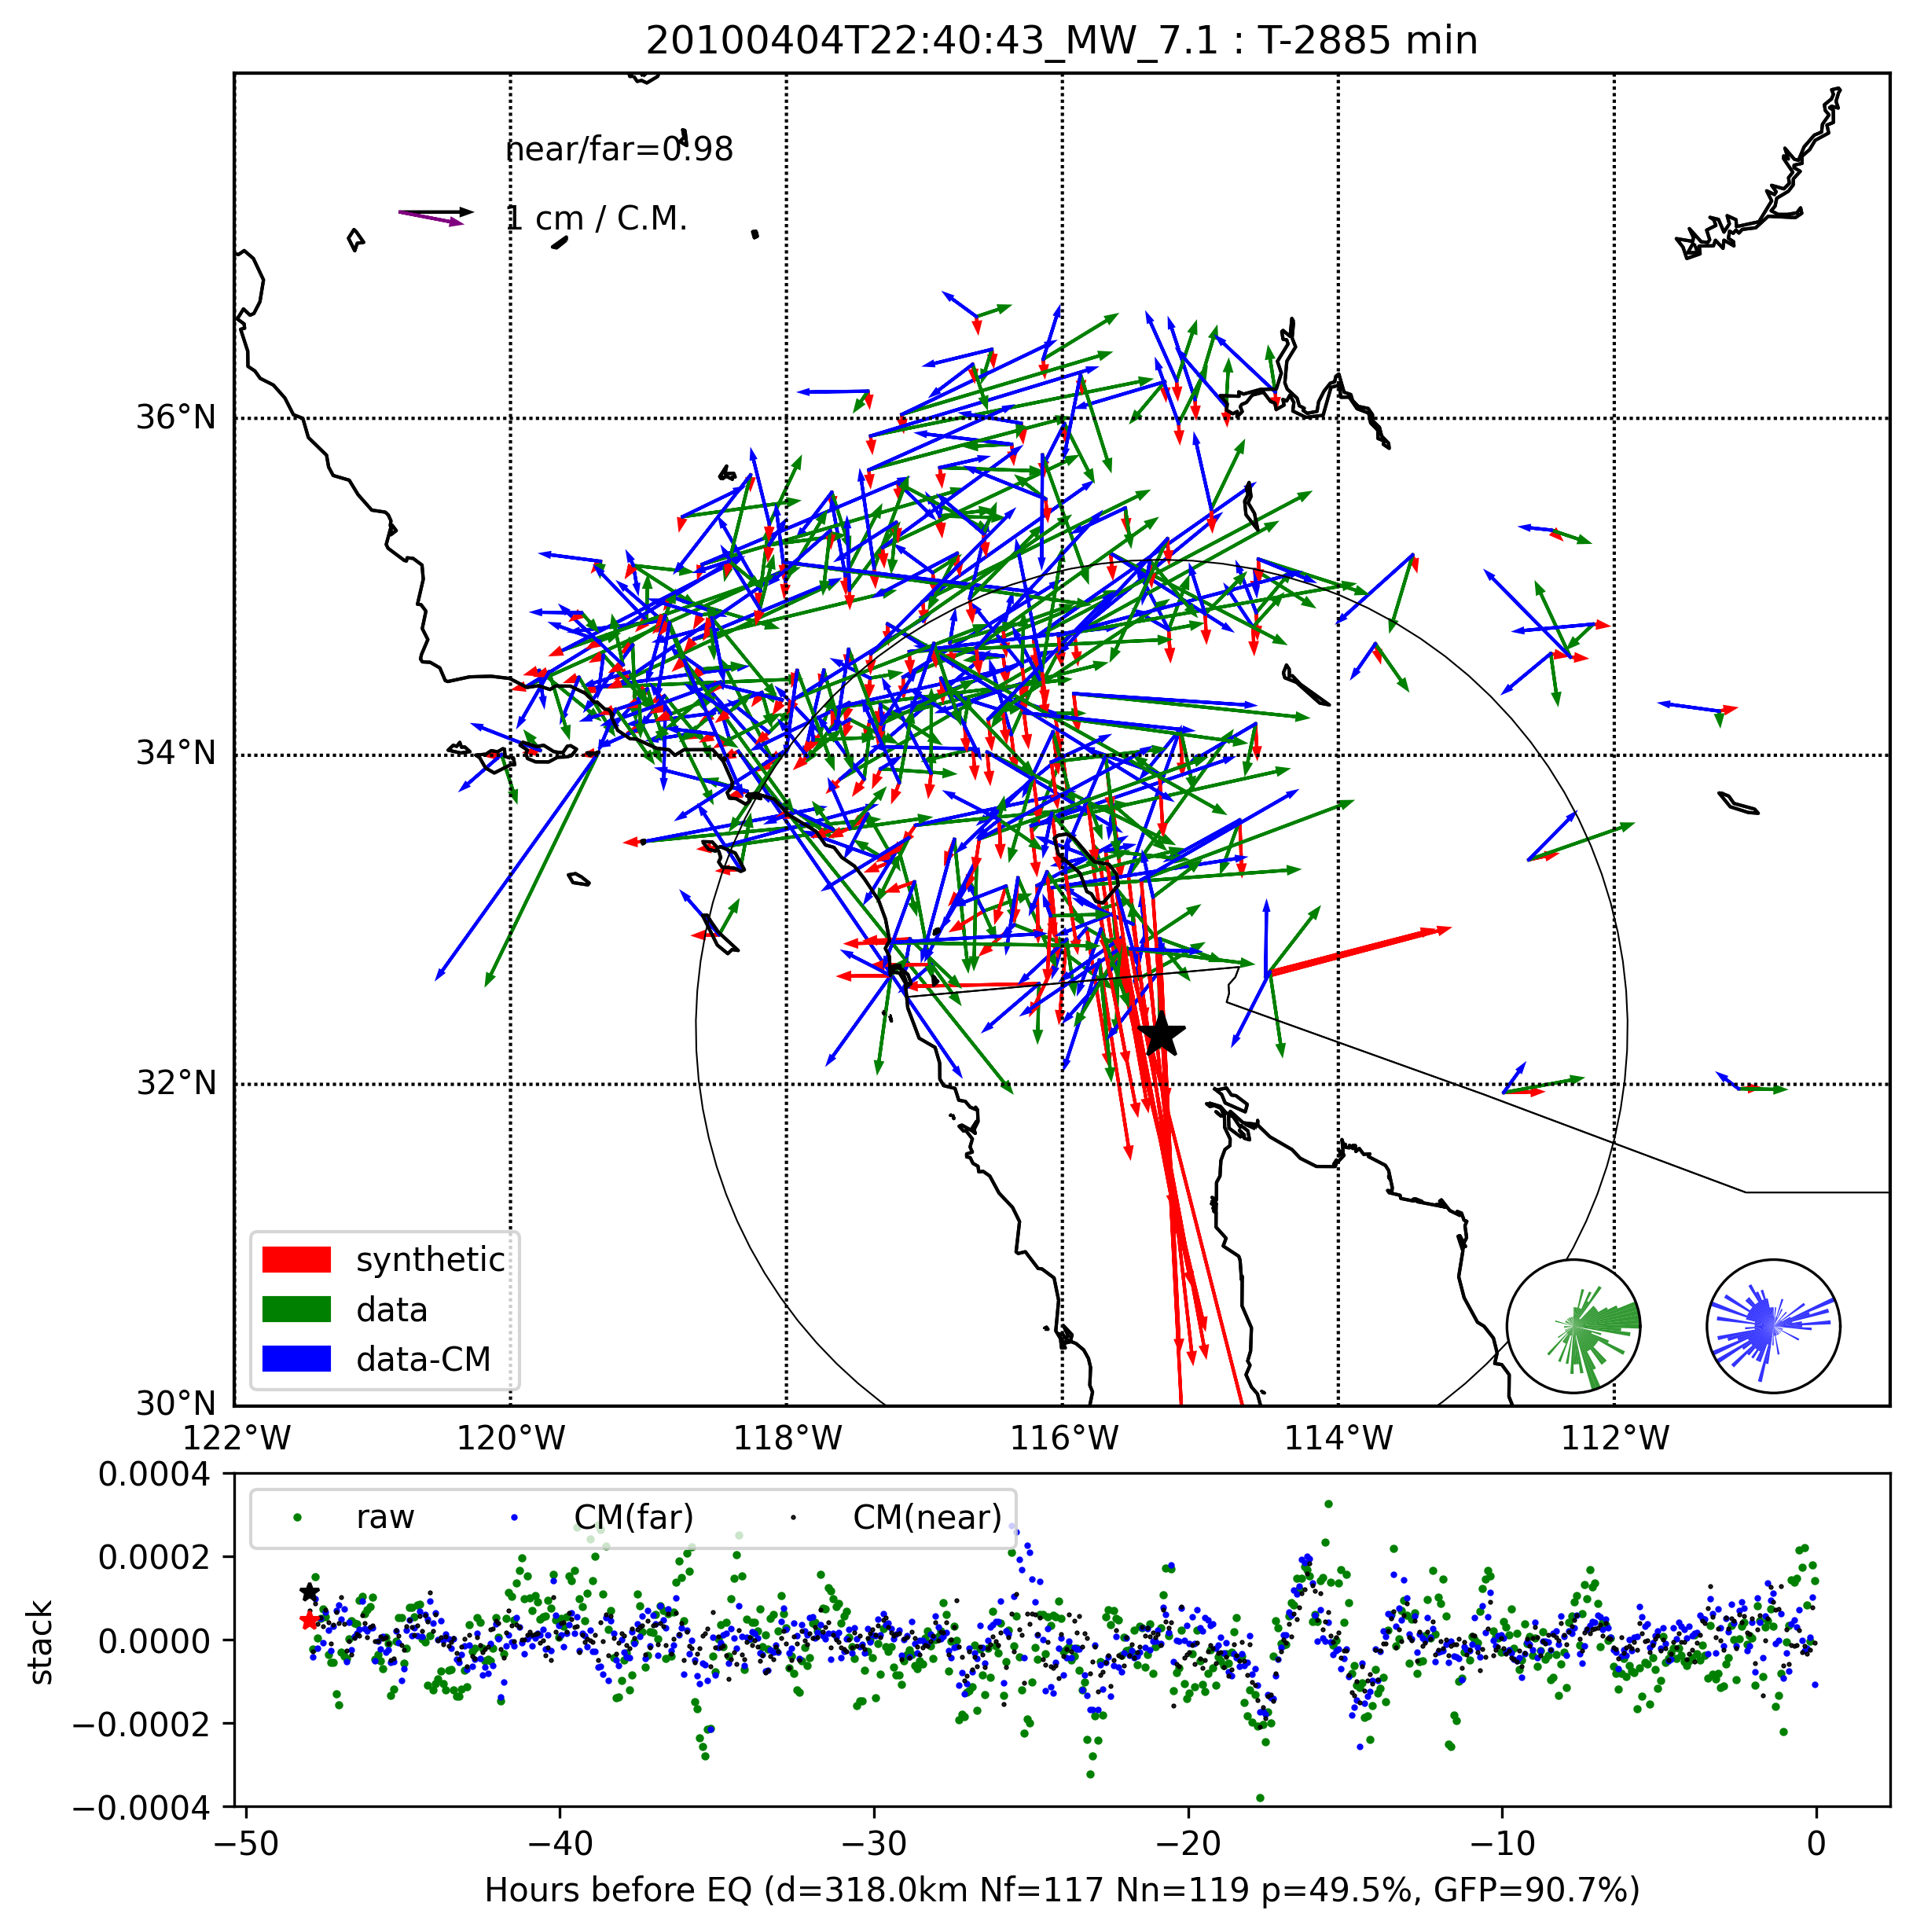

In [ ]:

# KEB: Create map movies for earthquakes

use_cor_cm = False

dynamic_dtcm = True

use_ts_ylim = True
ts_ylim = 0.0004

# Perentile station distance for cutoff
dtcm_pct=50

plt.rcParams["axes.formatter.limits"] = (-99, 99)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def calc_new_coord(lat1, lon1, rad, dist):
    """
    Calculate coordinate pair given starting point, radial and distance
    Method from: http://www.geomidpoint.com/destination/calculation.html
    """

    flat = 298.257223563
    a = 2 * 6378137.00
    b = 2 * 6356752.3142

    # Calculate the destination point using Vincenty's formula
    f = 1 / flat
    sb = np.sin(rad)
    cb = np.cos(rad)
    tu1 = (1 - f) * np.tan(lat1)
    cu1 = 1 / np.sqrt((1 + tu1*tu1))
    su1 = tu1 * cu1
    s2 = np.arctan2(tu1, cb)
    sa = cu1 * sb
    csa = 1 - sa * sa
    us = csa * (a * a - b * b) / (b * b)
    A = 1 + us / 16384 * (4096 + us * (-768 + us * (320 - 175 * us)))
    B = us / 1024 * (256 + us * (-128 + us * (74 - 47 * us)))
    s1 = dist / (b * A)
    s1p = 2 * np.pi

    while (abs(s1 - s1p) > 1e-12):
        cs1m = np.cos(2 * s2 + s1)
        ss1 = np.sin(s1)
        cs1 = np.cos(s1)
        ds1 = B * ss1 * (cs1m + B / 4 * (cs1 * (- 1 + 2 * cs1m * cs1m) - B / 6 * \
            cs1m * (- 3 + 4 * ss1 * ss1) * (-3 + 4 * cs1m * cs1m)))
        s1p = s1
        s1 = dist / (b * A) + ds1

    t = su1 * ss1 - cu1 * cs1 * cb
    lat2 = np.arctan2(su1 * cs1 + cu1 * ss1 * cb, (1 - f) * np.sqrt(sa * sa + t * t))
    l2 = np.arctan2(ss1 * sb, cu1 * cs1 - su1 * ss1 * cb)
    c = f / 16 * csa * (4 + f * (4 - 3 * csa))
    l = l2 - (1 - c) * f * sa * (s1 + c * ss1 * (cs1m + c * cs1 * (-1 + 2 * cs1m * cs1m)))
    d = np.arctan2(sa, -t)
    finaltc = d + 2 * np.pi
    backtc = d + np.pi
    lon2 = lon1 + l

    return (np.rad2deg(lat2), np.rad2deg(lon2))


def shaded_great_circle(m, lat_0, lon_0, dist=100, alpha=0.2, col='k'):  # dist specified in nautical miles
    theta_arr = np.linspace(0, np.deg2rad(360), 100)
    lat_0 = np.deg2rad(lat_0)
    lon_0 = np.deg2rad(lon_0)

    coords_new = []

    for theta in theta_arr:
        coords_new.append(calc_new_coord(lat_0, lon_0, theta, dist))

    lat = [item[0] for item in coords_new]
    lon = [item[1] for item in coords_new]

    x, y = m(lon, lat)
    m.plot(x, y, col, linewidth=0.5)

def map_vectors(map, lon, lat, u, v):
    x, y = map(lon, lat)
    x1, y1 = map(lon+u, lat+v)
    u_map, v_map = x1-x, y1-y

    # Rescale the magnitudes of the vectors...

    mag_scale = np.hypot(u_map, v_map) / np.hypot(u, v)
        
    u_map /= mag_scale
    v_map /= mag_scale

    return (u_map, v_map)


for eq in used_eqs:

    # Select a specific earthquake here
    if eq not in selected_eqs:
        continue
    
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    if len(np_code) < 20:
        print('Too few sites: {} {}'.format(eq, len(np_code[0])))
        continue
    else:
        print('Running {} {}'.format(eq, len(np_code[0])))

    # Find the earthquake source parameters in the SCARDEC file
    I_eq = np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0]

    Ns, st_dist = [], []

    # Get the list of stations, and their locations
    np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
    st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))

    # Get the pre-calculated Greens functions of the earthquake
    syn_east = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/synthetics.txt',dtype=float,usecols=1))
    
    # Get the pre-calculated statistics
    sj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    sg2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))

    T = np.zeros((np_code.shape[0],2,nsample))

    Nst = np_code.shape[0]
    Ns.append(Nst)
    st_dist = np.zeros(Nst)
    
    # Read the time series data for each station and save in an array T, also calculate station distances from EQ
    for i in range(Nst):
        ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+np_code[i]+'.dat')
        T[i,0,:] = ts[:,7] - np.median(ts[0:nd,7]) 
        T[i,1,:] = ts[:,8] - np.median(ts[0:nd,8])
        st_dist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000

    # Can run for different cutoff distances
    for dtcm in [300]: 
    
        # Select sites farther away than the cutoff distance
        if dynamic_dtcm: 
            dtcm=np.ceil(np.percentile(st_dist, dtcm_pct))
            print('Using {}% percentile station distance as cutoff: {}'.format(dtcm_pct, dtcm))
            valstr='median ({} km)'.format(dtcm)
            labelstr='median'
        else:
            valstr='{} km'.format(dtcm)
            labelstr='{}'.format(dtcm)
            
        Icm = np.where(st_dist>dtcm)
        Icm_near = np.where(st_dist<=dtcm)
        
        N_near=len(Icm_near[0])
        N_far=len(Icm[0])
        
        print('Selected ' + str(len(Icm[0])) + ' sites out of ' + str(len(st_lon)))
        
        # Icm[0] is an array of indices of sites farther than the cutoff distance

        # subtract the common mode of the Green's functions 
        gcm_e = syn_east - np.mean(syn_east[Icm[0]])
        gcm_n = syn_north - np.mean(syn_north[Icm[0]])

        # Calculate the common mode of the data, using far-field sites only, per time slice
        Tcm = np.mean(T[Icm[0],:,:],axis=0)
        
        # Calculate the common mode of the data, using near-field sites only, per time slice
        Tcm_near = np.mean(T[Icm_near[0],:,:],axis=0)

        # Subtract the common mode from the time series data
        Td = T - Tcm
        Td_near = T - Tcm_near

        # Td[N][0] is the east component of site N, common mode corrected
        # Td[N][1] is the north component of site N, common mode corrected

        # Original stack
        eq_stack_o = np.dot(syn_east/sj2,T[:,0,:]) + np.dot(syn_north/sj2,T[:,1,:])

        # Common mode corrected stack, far
        eq_stack = np.dot(syn_east/sj2,Td[:,0,:]) + np.dot(syn_north/sj2,Td[:,1,:])
        
        # Common mode corrected stack, near
        eq_stack_near = np.dot(syn_east/sj2,Td_near[:,0,:]) + np.dot(syn_north/sj2,Td_near[:,1,:])

        # Common mode stack
        eq_stack_cm = sum(syn_east/sj2)*Tcm[0,:] + sum(syn_north/sj2)*Tcm[1,:]            
        eq_stack_cm_near = sum(syn_east/sj2)*Tcm_near[0,:] + sum(syn_north/sj2)*Tcm_near[1,:]            
   
        stack_cor, stack_orig = 0, 0
        # Stack the common mode corrected synthetic against the original synthetic to see how much potential
        # signal is lost
        
        for i in range(len(st_lat)):
            vector_a=[gcm_e[i], gcm_n[i]]
            vector_o=[syn_east[i], syn_north[i]]
            if np.dot(vector_o, vector_o) != 0:
                vector_d = np.asarray(vector_o) * (np.dot(vector_a, vector_o) / np.dot(vector_o, vector_o))
                stack_cor = stack_cor + np.dot(vector_a, vector_o) / np.linalg.norm(vector_o)
                stack_orig = stack_orig + np.dot(vector_o, vector_o) / np.linalg.norm(vector_o)
        stack_expected=round(stack_cor / stack_orig * 100,1)
        print('Preservation ratio = {}'.format(stack_expected))

        ymaxval=max(eq_stack_o)*1.2
        a=max(st_dist)*2E7 # ad-hoc scaling factors for plotting
        b=a/1000/2
        
        # Calculate the time in hours for each 5 minute sample (x-axis coordinate)
        t = [0]*nsample
        for i in range(nsample):
            t[i] = -48 * (nsample-1-i)/nsample - 2.5/60 

        data_len_far, data_len_near = [], []
        for j in range(nsample):
            df, dn = 0,0

            for k in range(len(st_lon)):
                if st_dist[k] > dtcm:
                    df=df+np.sqrt(T[k][0][j]*T[k][0][j] + T[k][1][j]*T[k][1][j])
                else:
                    dn=dn+np.sqrt(T[k][0][j]*T[k][0][j] + T[k][1][j]*T[k][1][j])
            if len(Icm_near[0]) > 0:
                data_len_near.append(dn/len(Icm_near[0]))
            else:
                data_len_near.append(0)
            if len(Icm[0]) > 0:    
                data_len_far.append(df/len(Icm[0]))
            else:
                data_len_near.append(0)
            
        data_len_near=np.array(data_len_near)
        data_len_far=np.array(data_len_far)
        
        radiimax=0
        radii = np.zeros((nsample,90),dtype=np.int8)
        radii_d=radii.copy()
            
        
        N=90
        
        for j in range(nsample):
            data_phi = []
            data_phi_d = []
            for k in range(len(st_lon)):
                data_phi.append((math.atan2(-T[k][1][j],-T[k][0][j])))
                data_phi_d.append((math.atan2(-Td[k][1][j],-Td[k][0][j])))
            radii[j][:] = np.array(np.histogram(data_phi, N)[0])
            radii_d[j][:] = np.array(np.histogram(data_phi_d, N)[0])
    
        radiimax=max(np.percentile(radii,95),np.percentile(radii_d,95))
        max_height = radiimax

        j=0

        # Uncomment to plot only one time step, to test the code
        for v in range(nsample,nsample-1,-1):
            
        # Uncomment to plot for all time steps, to make a movie
#         for v in range(nsample,0,-1):
            w=-v
            print(w)   

            mytitle='{} : T-{} min'.format(eq, int((-w+1)*5))

            os.makedirs(fig_dir+'/Figure_S6a_{}_{}/'.format(eq, labelstr), exist_ok=True)            
            
            # If it's the first time step, create the basemap and plot the data

            if j==0:
                buffer_d=1
                minlon=np.floor(min(min(st_lon),eq_lon[I_eq])-buffer_d)
                minlat=np.floor(min(min(st_lat),eq_lat[I_eq])-buffer_d)
                maxlon=np.ceil(max(max(st_lon),eq_lon[I_eq])+buffer_d)
                maxlat=np.ceil(max(max(st_lat),eq_lat[I_eq])+buffer_d)
                h =(max(st_lon)-min(st_lon))*np.cos((max(st_lat)+min(st_lat))/2*np.pi/180)/(max(st_lat)-min(st_lat))
                
    
                # Create a Figure, which doesn't have to be square.
                fig = plt.figure(layout='constrained', dpi=300, figsize=(8,8))
                
                # Create the main Axes, leaving 25% of the figure space at the top and on the
                # right to position marginals.

                mapax = fig.add_gridspec(top=1, right=1).subplots()
                mapax.set(aspect=1)

                map = Basemap(projection='merc', lat_0 = (minlat+maxlat)/2, lon_0 = (minlon+maxlon)/2,
                    resolution = 'i', area_thresh = 0.01,
                    llcrnrlon=minlon, llcrnrlat=minlat,
                    urcrnrlon=maxlon, urcrnrlat=maxlat,  ax=mapax)

                map.drawcoastlines()
                map.drawcountries()
                map.drawmapboundary()
                
                # Each map has a different X/Y aspect ratio, so to draw a square box for the rose diagram
                # we need to calculate the size of the box and add a new axis accordingly.
                
                # percent of vertical axis width
                
                windscale=0.15 
                lims=map(maxlon, maxlat)
                hw=lims[1]/lims[0]
                
                # Add the axis for the time series 
                tsax = mapax.inset_axes([0, -0.3, 1, 0.25])
                
                # Add the axis for the wind diagram at lower right of the map
                windax= mapax.inset_axes([1-(2*windscale*hw)-0.01, 0.01, windscale*hw, 0.1], polar=True)
                windax2=mapax.inset_axes([1-windscale*hw-0.01, 0.01, windscale*hw, 0.1], polar=True)

                # N=Number of bins covering the 360 degree range
                N  = 90
                bottom = 0
                
                theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
                
                width = (2*np.pi) / N

                bars = windax.bar(theta, radii[j], width=width, bottom=bottom)
                windax.xaxis.set_tick_params(labelbottom=False)
                windax.yaxis.set_tick_params(labelleft=False)
                
                # Use custom colors and opacity
                for r, bar in zip(radii, bars):
                    bar.set_facecolor('green')
                    bar.set_alpha(0.8)
            
                bars2 = windax2.bar(theta, radii_d[j], width=width, bottom=bottom)
                windax2.xaxis.set_tick_params(labelbottom=False)
                windax2.yaxis.set_tick_params(labelleft=False)
                
                # Use custom colors and opacity
                for r, bar in zip(radii_d, bars2):
                    bar.set_facecolor('blue')
                    bar.set_alpha(0.8)
            
                windax.grid(False)
                windax2.grid(False)
                windax.set_ylim((0, max_height))
                windax2.set_ylim((0, max_height))

                fig.autolayout : True

                map.drawcoastlines()
                map.drawcountries()
                map.drawmapboundary()

                shaded_great_circle(map, eq_lat[I_eq], eq_lon[I_eq], dtcm*1000*2, col='k')
                
                map.drawparallels(np.arange(minlat,maxlat,2.),labels=[2,0,0,2])
                map.drawmeridians(np.arange(minlon,maxlon,2.),labels=[2,0,0,2])

                acr, acb, acg, cm1, t1, t2 = [], [], [], [], [], []
                    
                eq_longs,eq_lats=map(eq_lon[I_eq],eq_lat[I_eq])
                mapax.plot(eq_longs,eq_lats,'*k',markersize=15)

                # Plot a scale and common mode vector
                leglon,leglat=map(minlon+(maxlon-minlon)/10, maxlat-(maxlat-minlat)/10)  
                mapax.arrow(leglon, leglat,10*b*1E-3,0,width = 0.01,color='black',head_width=5000, head_length=7000)
                
                cm1.append(mapax.arrow(leglon, leglat,Tcm[0][j]*b,Tcm[1][j]*b,width = 0.01,color='purple',head_width=5000, head_length=7000))

                
                leglon,leglat=map(minlon+(maxlon-minlon)/10+0.75, maxlat-(maxlat-minlat)/10-0.1)  
                mapax.text(leglon,leglat,"1 cm / C.M.")
                
                leglon,leglat=map(minlon+(maxlon-minlon)/10+0.75, maxlat-(maxlat-minlat)*0.5/10-0.1)  
                t2=mapax.text(leglon,leglat,'n/f = {}'.format(int(data_len_near[j]/data_len_far[j]*100)/100))
                              
                st_longs,st_lats=map(st_lon,st_lat)

                x, y = map(st_lon, st_lat)
                syn_east_map, syn_north_map = map_vectors(map, st_lon, st_lat, syn_east, syn_north)
                data_east_map, data_north_map = map_vectors(map, st_lon, st_lat, T[:,0,j], T[:,1,j])
                cor_east_map, cor_north_map = map_vectors(map, st_lon, st_lat, Td[:,0,j], Td[:,1,j])
                
                
                i=0
                acr.append(mapax.arrow(x[i],y[i],syn_east_map[i]*a,syn_north_map[i]*a,width = 0.01,color='red',head_width=5000, head_length=7000,label="synthetic"))
                acg.append(mapax.arrow(x[i],y[i],data_east_map[i]*b,data_north_map[i]*b,width = 0.01,color='green',head_width=5000, head_length=7000,label="data"))
                acb.append(mapax.arrow(x[i],y[i],cor_east_map[i]*b,cor_north_map[i]*b,width = 0.005,color='blue',head_width=3000, head_length=5000,label="data-CM"))

                for i in range(1,len(st_lon)):
                    acr.append(mapax.arrow(x[i],y[i],syn_east_map[i]*a, syn_north_map[i]*a,width = 0.01,color='red',head_width=5000, head_length=7000))
                    acg.append(mapax.arrow(x[i],y[i],data_east_map[i]*b,data_north_map[i]*b,width = 0.01,color='green',head_width=5000, head_length=7000))
                    acb.append(mapax.arrow(x[i],y[i],cor_east_map[i]*b,cor_north_map[i]*b,width = 0.005,color='blue',head_width=3000, head_length=5000))


                mapax.legend(loc="lower left")
                    
                tsax.set_xlabel('Hours before EQ (d={}km Nf={} Nn={} p={}%, GFP={}%)'.format(dtcm, N_far, N_near, int(N_far/(N_far+N_near)*1000)/10, stack_expected))
                tsax.set_ylabel('stack')
                tsax.set_ylim([-ymaxval,ymaxval])
                tsax.plot(t,eq_stack_o,'g.', markersize=3,label="raw")
                tsax.plot(t,eq_stack,'b.', markersize=2,label="CM(far)")
                tsax.plot(t,eq_stack_near,'k.',markersize=1,label="CM(near)")
                tsax.legend(loc="upper left", ncol=3)
                
                if use_ts_ylim:
                    tsax.set_ylim([-ts_ylim, ts_ylim])
                    
                arrtmp=data_len_near/data_len_far
                
                b1=tsax.plot(t[0],eq_stack[0],'r*')
                b2=tsax.plot(t[0],eq_stack_o[0],'k*')
                                
            # Otherwise, just update the existing data in the plot

            else:
                data_east_map, data_north_map = map_vectors(map, st_lon, st_lat, T[:,0,j], T[:,1,j])
                cor_east_map, cor_north_map = map_vectors(map, st_lon, st_lat, Td[:,0,j], Td[:,1,j])

                for i in range(len(st_lon)):
                    acg[i].set_data(x=x[i], y=y[i], dx=data_east_map[i]*b,dy=data_north_map[i]*b,width = 0.01,head_width=5000, head_length=7000)
                    acb[i].set_data(x=x[i], y=y[i], dx=cor_east_map[i]*b,dy=cor_north_map[i]*b,width = 0.005,head_width=3000, head_length=5000)

            b1[0].set_xdata([t[j]])
            b1[0].set_ydata([eq_stack[j]])
            b2[0].set_xdata([t[j]])
            b2[0].set_ydata([eq_stack_o[j]])
            cm1[0].set_data(dx=Tcm[0][j]*b,dy=Tcm[1][j]*b)

            bars.datavalues = radii[j]
            for rect in range(len(bars)):
                bars[rect].set_height(bars.datavalues[rect])
                
            bars2.datavalues = radii_d[j]
            for rect in range(len(bars2)):
                bars2[rect].set_height(bars2.datavalues[rect])
            fig.canvas.draw()
            fig.canvas.flush_events()
                            
            t2.set_text('near/far={}'.format(int(data_len_near[j]/data_len_far[j]*100)/100))

            mapax.set_title('{}'.format(mytitle))

            plt.savefig(fig_dir+'/Figure_S6a_{}_{}/Movie_{}_{}'.format(eq, labelstr, eq, labelstr)+'_{0:05d}.png'.format(j))

            j=j+1

        # Uncomment to avoid opening huge numbers of plots when creating movies
#         plt.close()
    
  

In [20]:
# Calculate common modes, the variance reduction after removing these common modes (excluding the last 2 hours),
# and then the stacks after removing the common modes

Nscm_near = 0        # Minimum number of distant (farther away than dtcm) stations to calculate common modes 
Nscm_far = 10
dtcm=200

eq_stack_o, eq_stack = np.zeros([len(used_eqs),nsample]), np.zeros([len(used_eqs),nsample])
eq_stack_cm = np.zeros([len(used_eqs),nsample])
stdX, stdXd = np.zeros([len(used_eqs),1]), np.zeros([len(used_eqs),1])
sg = np.zeros(len(used_eqs))
sg_cm = np.zeros(len(used_eqs))
Ns, Ns_200, var_red, var_eq = [], [], [], []
we = 24
k = 0

seltype='far'   # near | far   -   calculate common mode from near sites or far sites given cutoff=dtcm
new_eqlist = []

print('Calculating common mode using only {} sites at cutoff {}'.format(seltype, dtcm))

nd=int(nsample/2)

for eq in used_eqs:

    # Exclude earthquakes here if desired
    # if eq in ['20100404T22:40:43_MW_7.1','20110311T05:46:24_MW_9.0']: 
    #    continue
        
    print('Working on earthquake: '+eq)
    eq_dir = 'data_byEQ'+'/'+eq
    code = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=str,usecols=0))
    syn_east = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics.txt',dtype=float,usecols=0))
    syn_north = np.atleast_1d(np.genfromtxt(eq_dir+'/synthetics.txt',dtype=float,usecols=1))
    st_lon = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=float,usecols=1))
    st_lat = np.atleast_1d(np.genfromtxt(eq_dir+'/station_list.txt',dtype=float,usecols=2))
    sj2 = np.atleast_1d(np.genfromtxt(eq_dir+'/sigmaj2.txt'))

    sg2 = np.atleast_1d(np.genfromtxt(eq_dir+'/sigmag2.txt'))
    T = np.zeros((code.shape[0],2,576))
    I_eq = np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0][0]
    
    Nst = code.shape[0]
    sj2_cm = np.zeros(Nst)

    st_dist = np.zeros(Nst)
    for i in range(Nst):
        ts = np.genfromtxt(eq_dir+'/TS_'+code[i]+'.dat')
        east = ts[:,7] - np.median(ts[0:nd,7]) 
        north = ts[:,8] - np.median(ts[0:nd,8])
        st_dist[i] = geo_spherical_distance(st_lon[i],st_lat[i],0,eq_lon[I_eq],eq_lat[I_eq],0,unit='dec_deg')/1000
        T[i,0,:], T[i,1,:] = east, north 
    
    Icm_near = np.where(st_dist<dtcm)
    
    if len(Icm_near[0]) <= Nscm_near:
        print('Rejected; fewer than {} closer than {} km'.format(Nscm_near, dtcm))
        continue
    
    Icm_far = np.where(st_dist>dtcm)
    
    if len(Icm_far[0]) <= Nscm_far:
        print('Rejected; fewer than {} farther than {} km'.format(Nscm_far, dtcm))
        continue
    
    if seltype=='near':
        Icm=Icm_near
    else:
        Icm=Icm_far
    
    new_eqlist.append(eq)
    
    Tcm = np.mean(T[Icm[0],:,:],axis=0)
    Td = T - Tcm
    X = np.vstack((T[:,0,:],T[:,1,:])).T
    Xd = np.vstack((Td[:,0,:],Td[:,1,:])).T

    # Recalculate sj2 - the noise level of each station - after common mode removal
    
    for i in range(Nst):
        north = Td[i,0,:]
        east = Td[i,1,:]
        east0, north0 = np.median(east[0:nd]), np.median(north[0:nd])
        norme, normn = np.linalg.norm(east[0:nd]-east0), np.linalg.norm(north[0:nd]-north0)
        sj2_cm[i] = norme*norme + normn*normn
    
    sg[k] = sum(np.divide(np.sqrt(sg2),sj2))
    
    sg_cm[k] = sum(np.divide(np.sqrt(sg2),sj2_cm))
    
    stdX[k]  = np.mean(np.std(X[:,0:nsample-we],axis=0))
    stdXd[k] = np.mean(np.std(Xd[:,0:nsample-we],axis=0))
    std_red = 100*(stdX[k][0]**2-stdXd[k][0]**2)/stdX[k][0]**2
    print('Variance reduction: '+str(round(std_red,1))+' % ('+')\n' )
    var_red.append(round(std_red,1))
    var_eq.append(eq)
    
    eq_stack_o[k,:] = np.dot(syn_east/sj2,T[:,0,:]) + np.dot(syn_north/sj2,T[:,1,:])
    eq_stack[k,:] = np.dot(syn_east/sj2_cm,Td[:,0,:]) + np.dot(syn_north/sj2_cm,Td[:,1,:])
    eq_stack_cm[k,:] = sum(syn_east/sj2_cm)*Tcm[0,:] + sum(syn_north/sj2_cm)*Tcm[1,:]
    
    k = k+1
    
stack = np.sum(eq_stack,axis=0)
stack_o = np.sum(eq_stack_o,axis=0)
stack_cm = np.sum(eq_stack_cm,axis=0)

Calculating common mode using only far sites at cutoff 200
Working on earthquake: 20130925T16:42:43_MW_7.0
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20110407T14:32:43_MW_7.1
Variance reduction: 27.7 % ()

Working on earthquake: 20231207T12:56:30_MW_7.0
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20121107T16:35:46_MW_7.3
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20071219T09:30:27_MW_7.1
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20030925T19:50:06_MW_8.1
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20140310T05:18:13_MW_7.0
Variance reduction: 19.7 % ()

Working on earthquake: 20150425T06:11:25_MW_7.9
Variance reduction: 12.9 % ()

Working on earthquake: 20110624T03:09:39_MW_7.3
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20230118T06:06:13_MW_7.1
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20171112T18:18:17_MW_7.3
Rejected; fewer than

Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20220918T06:44:13_MW_7.1
Variance reduction: 28.6 % ()

Working on earthquake: 20030821T12:12:49_MW_7.2
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20210729T06:15:49_MW_8.1
Variance reduction: 29.3 % ()

Working on earthquake: 20140418T14:27:24_MW_7.2
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20100527T17:14:46_MW_7.1
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20180110T02:51:33_MW_7.4
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20120110T18:36:59_MW_7.1
Rejected; fewer than 0 closer than 200 km
Working on earthquake: 20160416T23:58:36_MW_7.8
Rejected; fewer than 10 farther than 200 km
Working on earthquake: 20240101T07:10:09_MW_7.6
Variance reduction: 20.0 % ()

Working on earthquake: 20181130T17:29:29_MW_7.1
Variance reduction: 26.5 % ()

Working on earthquake: 20161208T17:38:46_MW_7.9
Rejected; fewer than 0 closer than 200 km
Work

Text(0, 0.5, 'Earthquake stacks')

<Figure size 1280x6400 with 0 Axes>

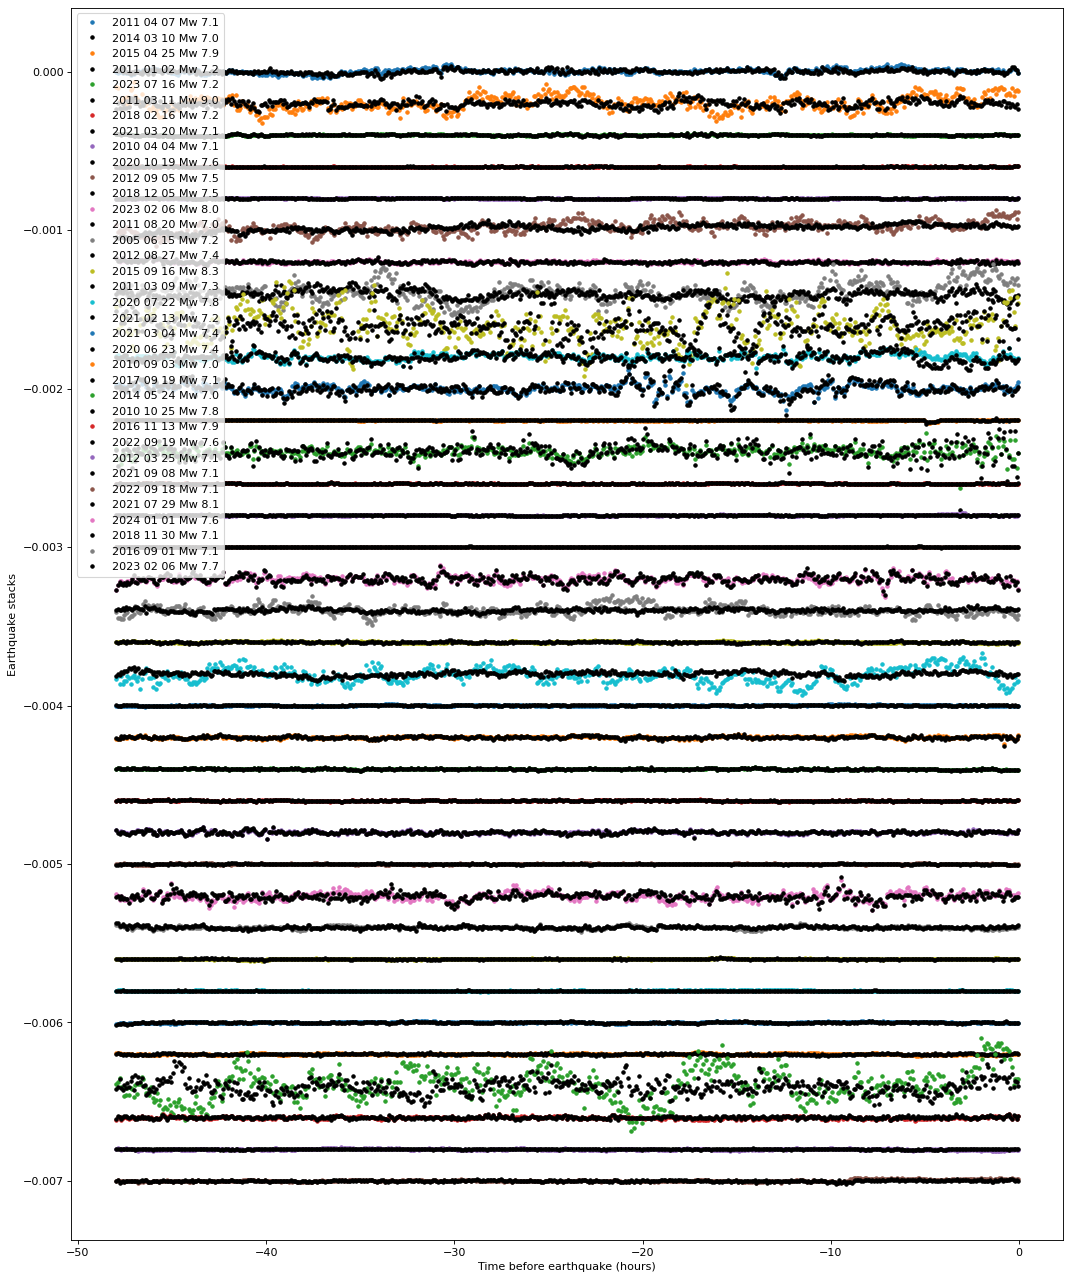

In [21]:
# Plot each earthquake stack before and after removing the common mode, using a fixed Y scale
plt.figure(figsize=(16, 80), dpi=80)

# Plot the stacks for the earthquakes with sigma > sg_threshold (Figure S5)

plt.figure(figsize=(16, 20), dpi=80)
ic, leg = 0, []
for i in range(len(new_eqlist)):
#     if sg1[i]>sg_threshold:
    plt.plot(t,eq_stack_o[i]-0.0002*ic,'.')
    plt.plot(t,eq_stack[i]-0.0002*ic,'k.')

    eq = new_eqlist[i]
    leg.append(eq[0:4]+' '+eq[4:6]+' '+eq[6:8]+' Mw '+eq[-3:len(eq)])
    ic = ic + 1
        
plt.legend(leg,loc=2)

    
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Earthquake stacks')



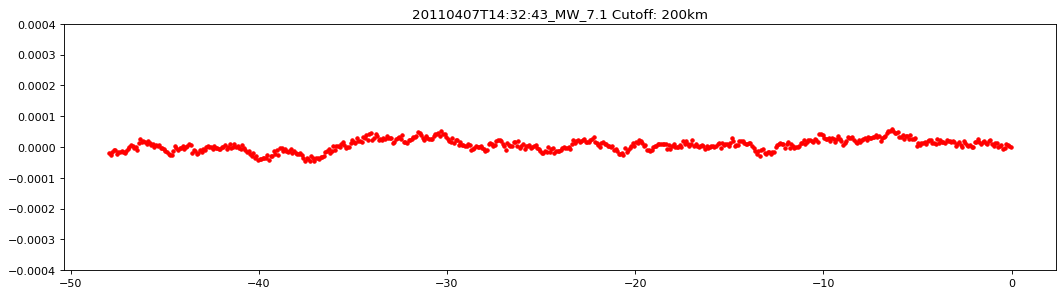

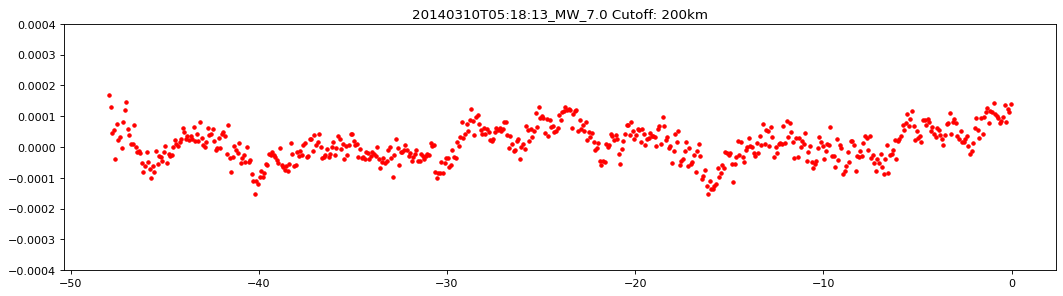

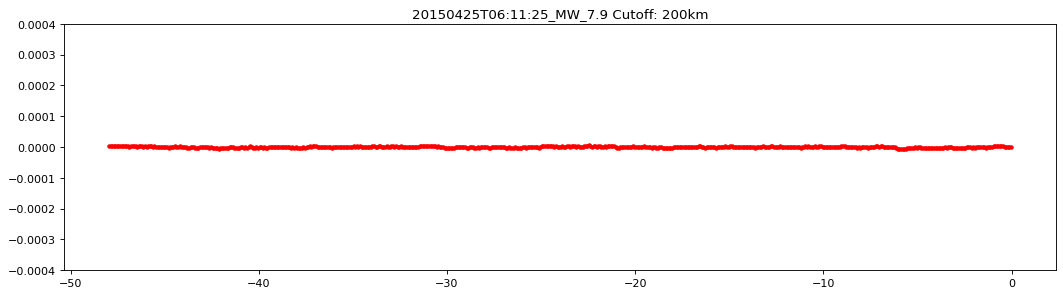

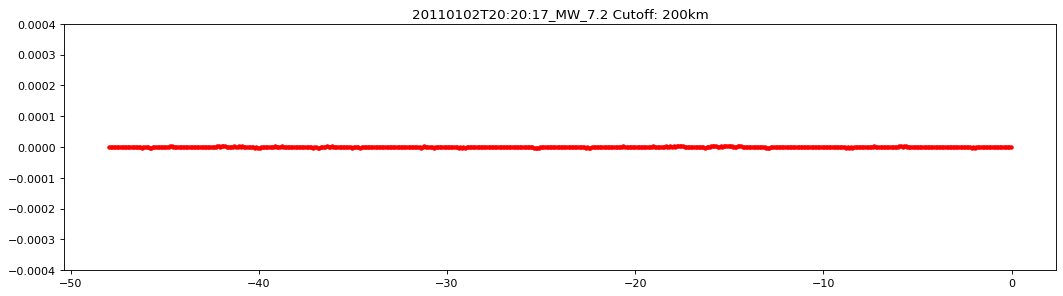

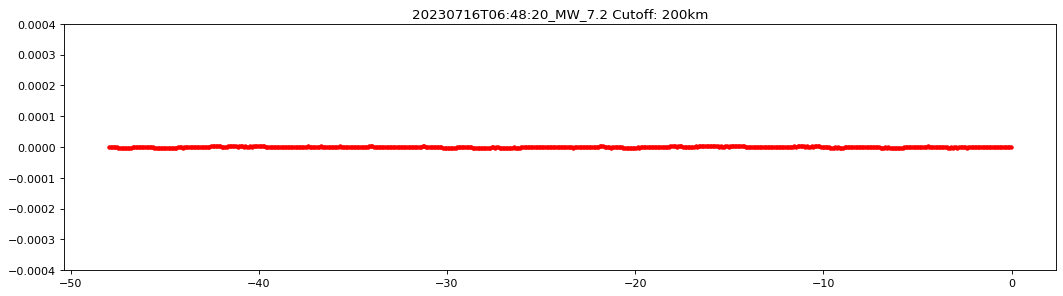

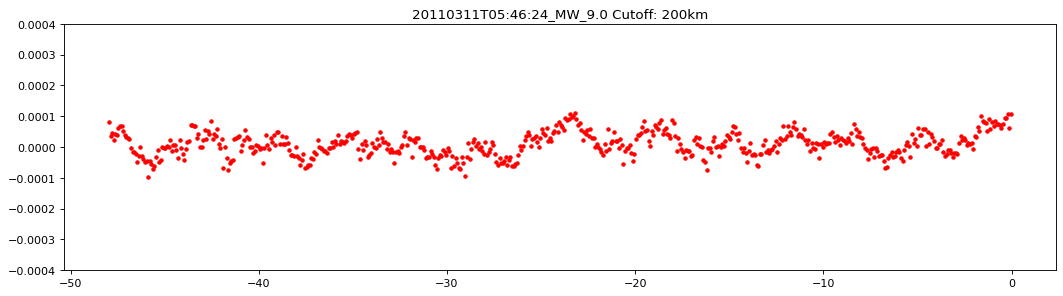

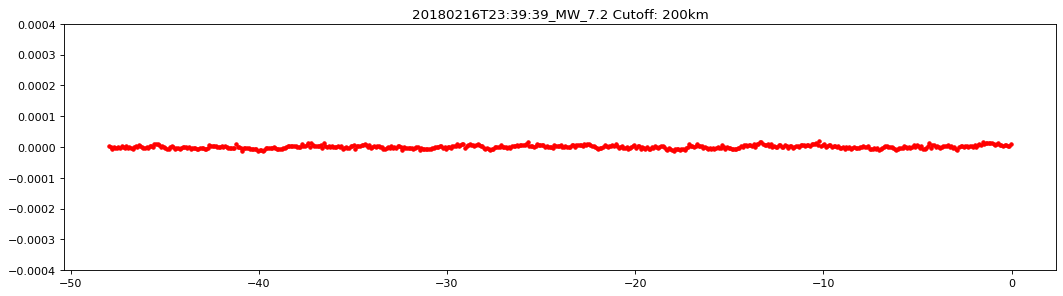

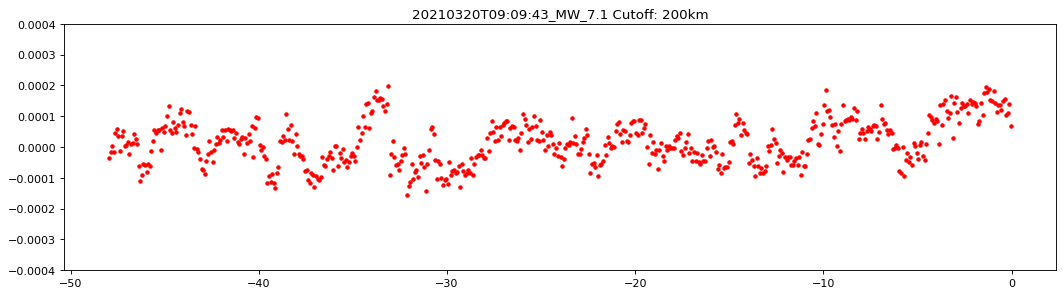

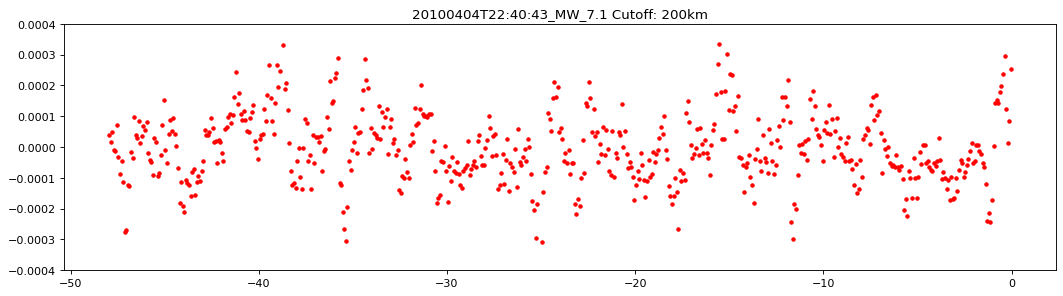

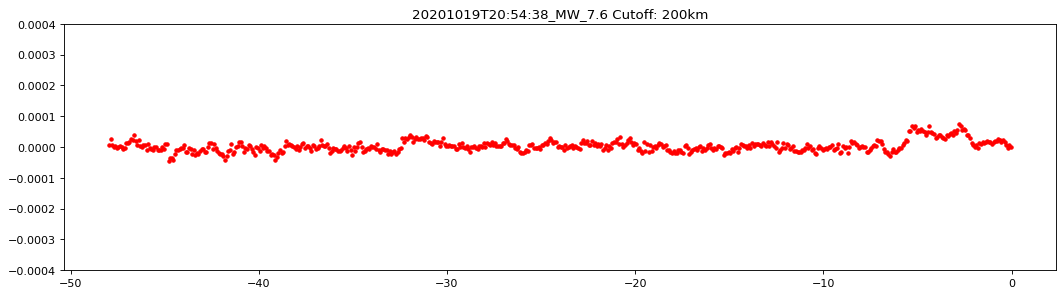

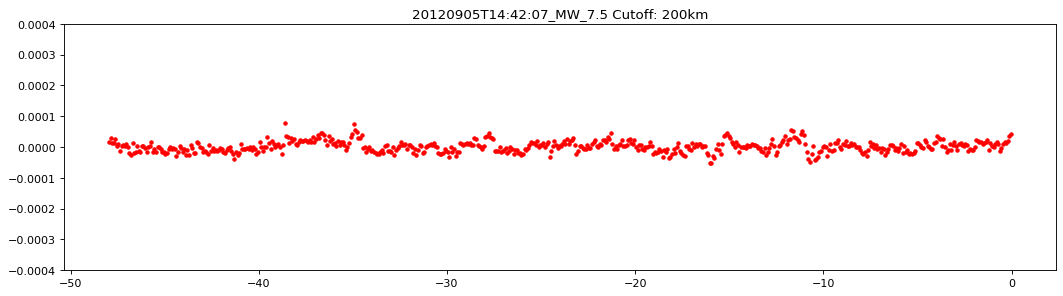

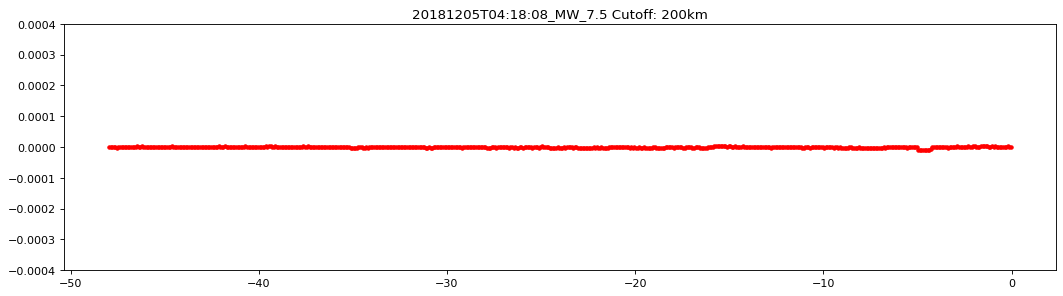

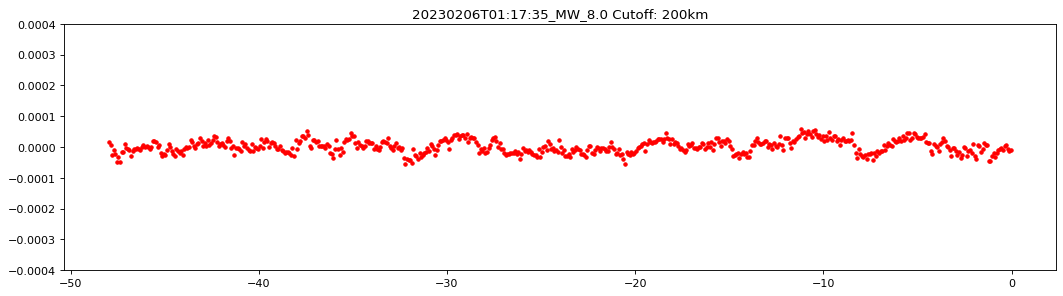

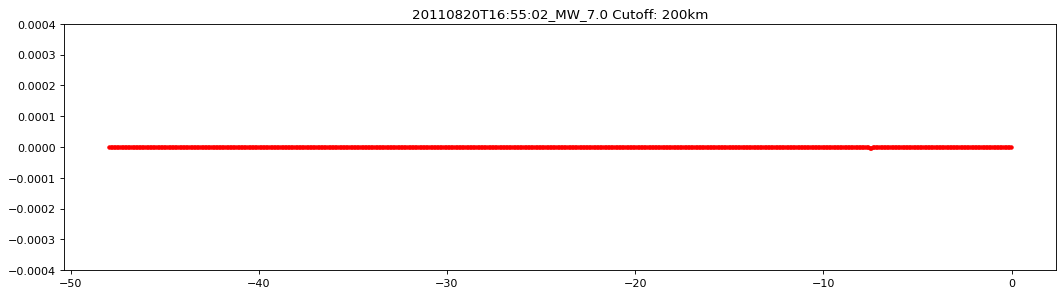

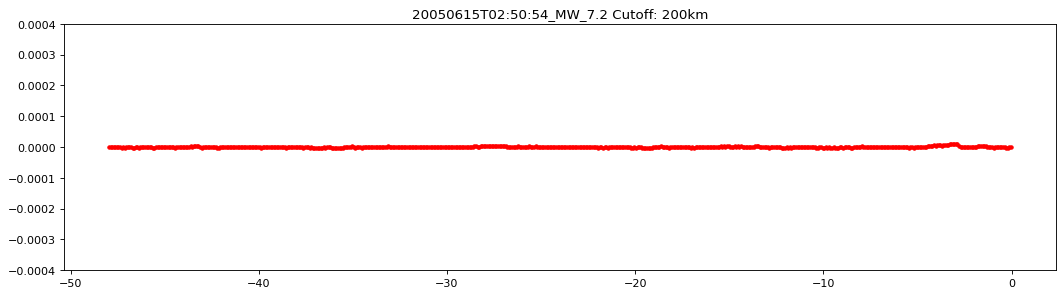

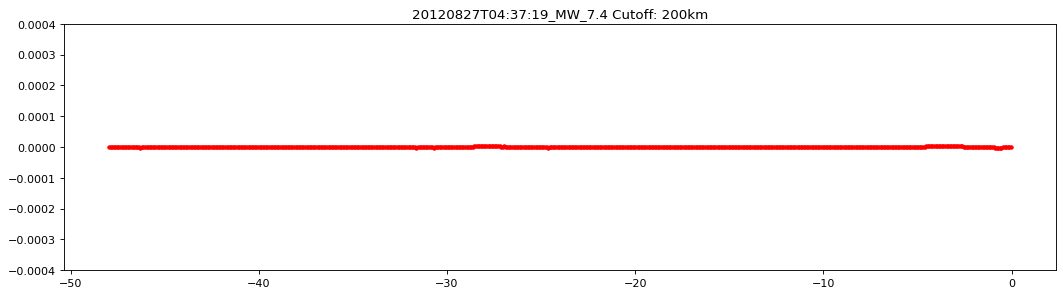

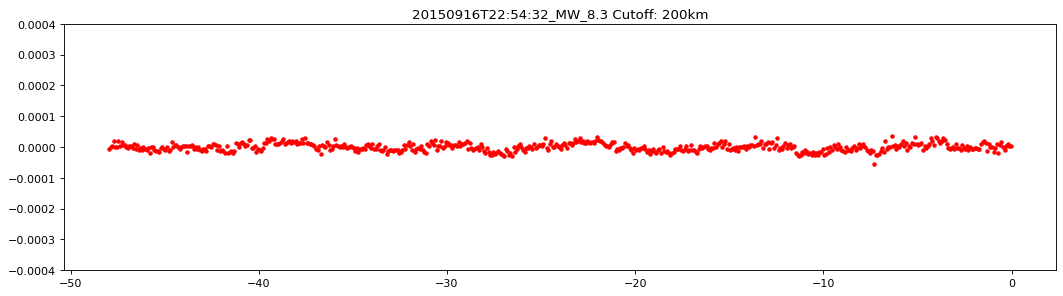

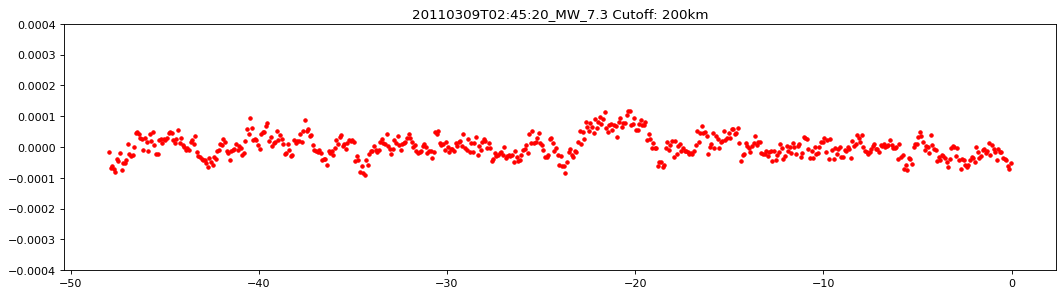

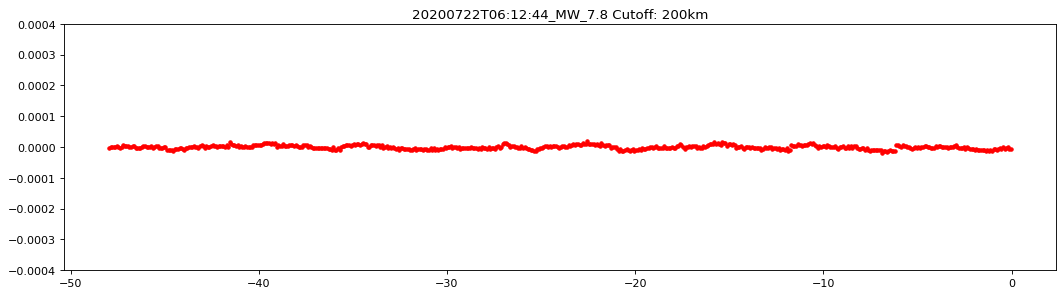

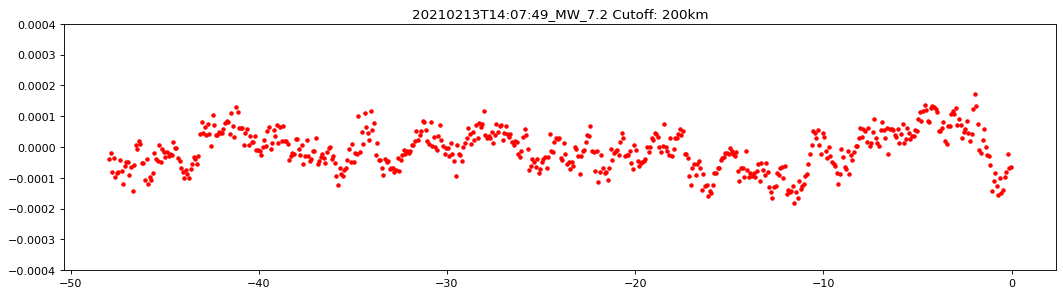

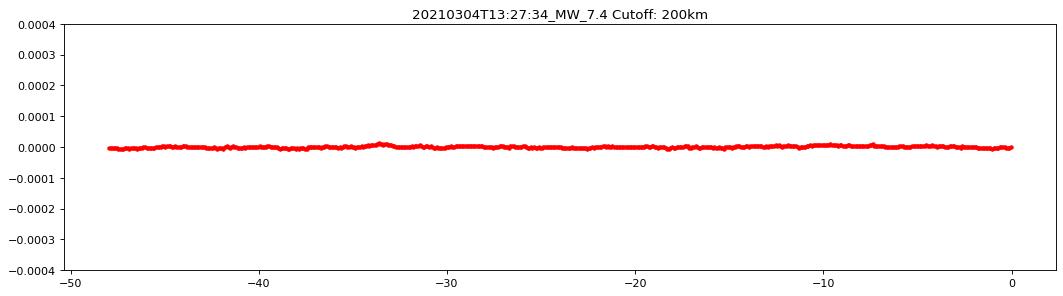

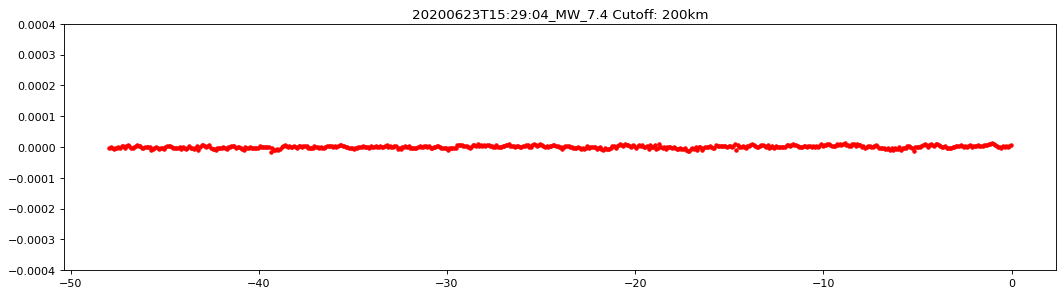

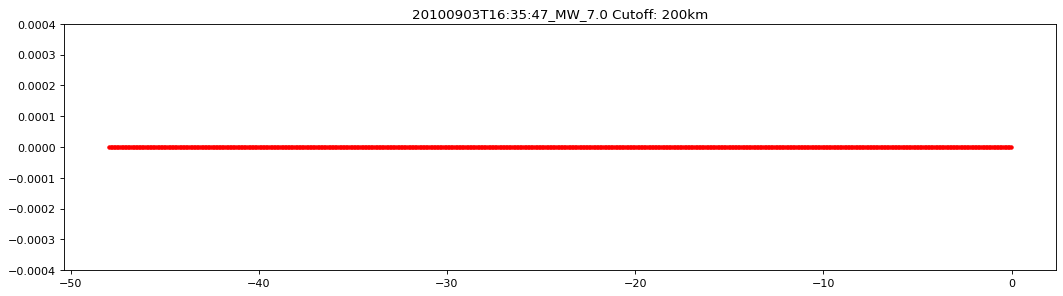

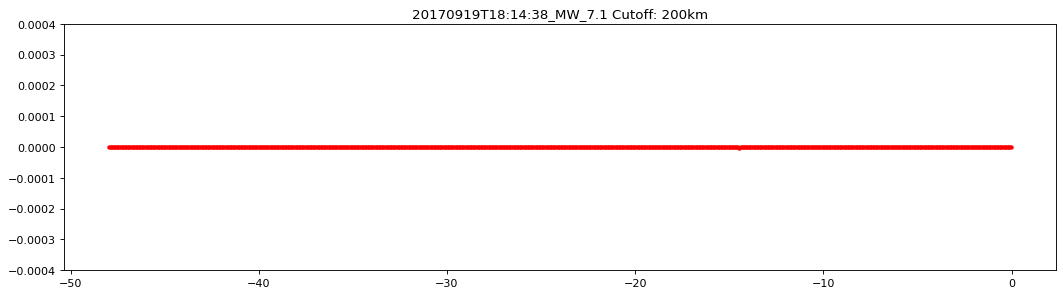

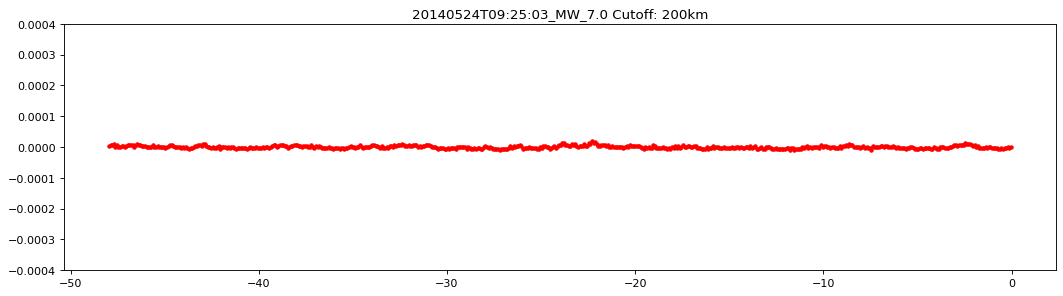

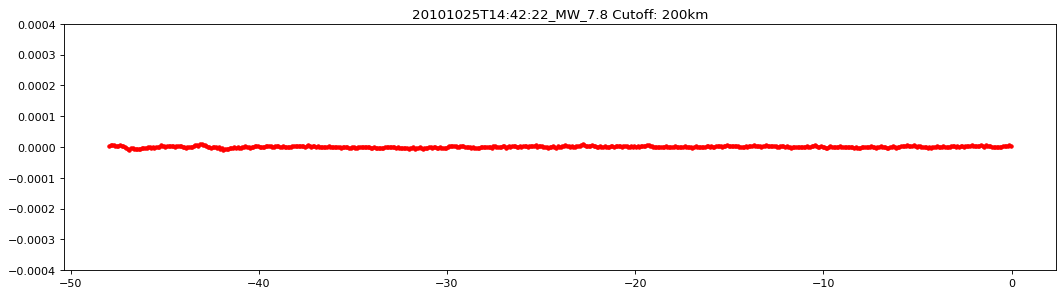

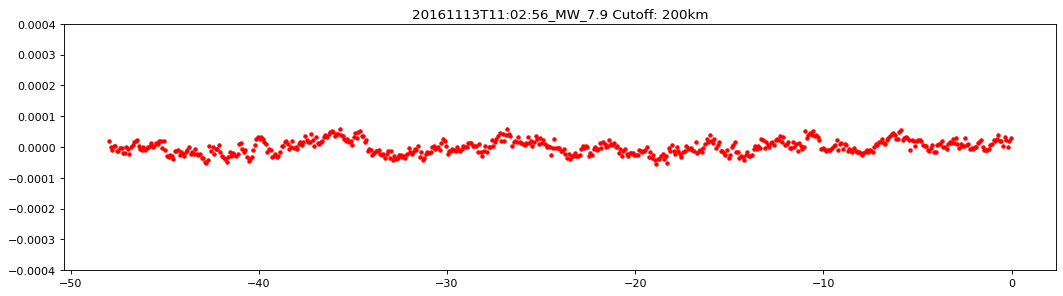

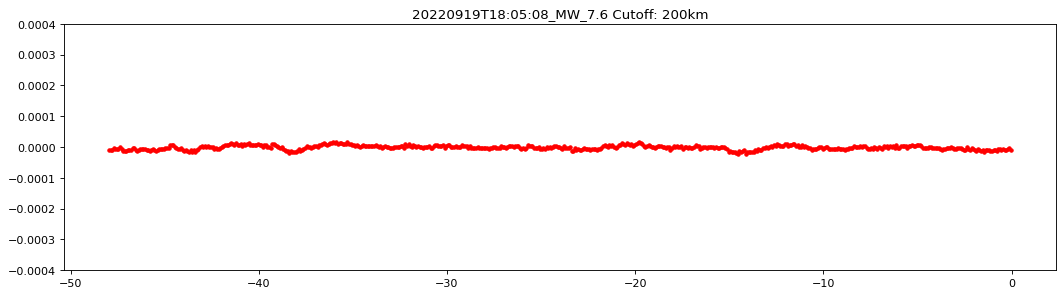

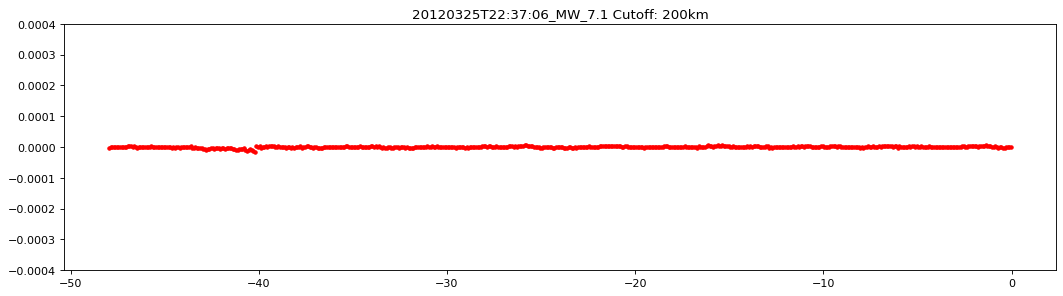

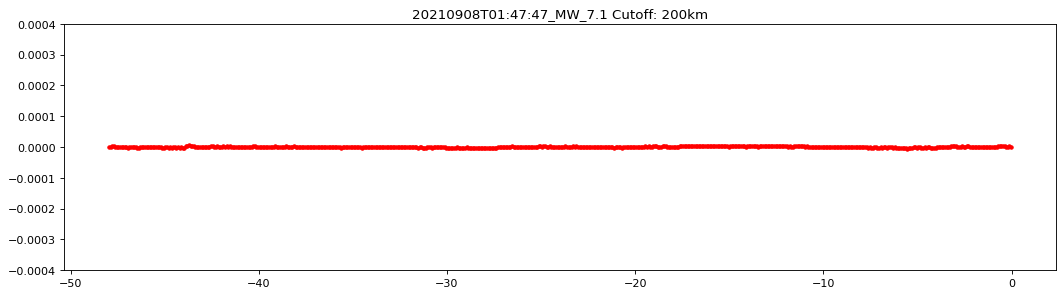

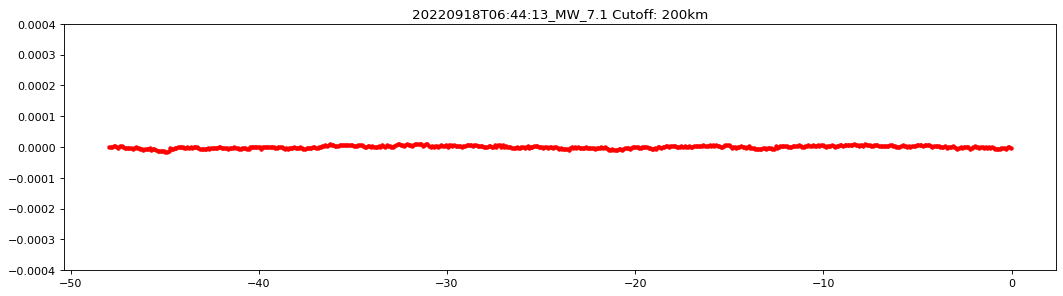

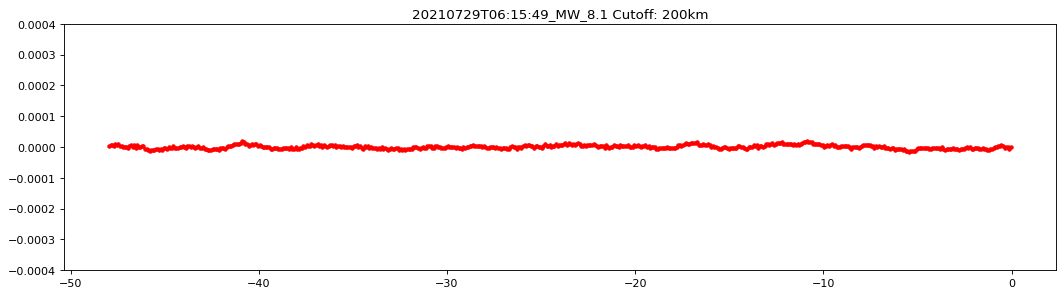

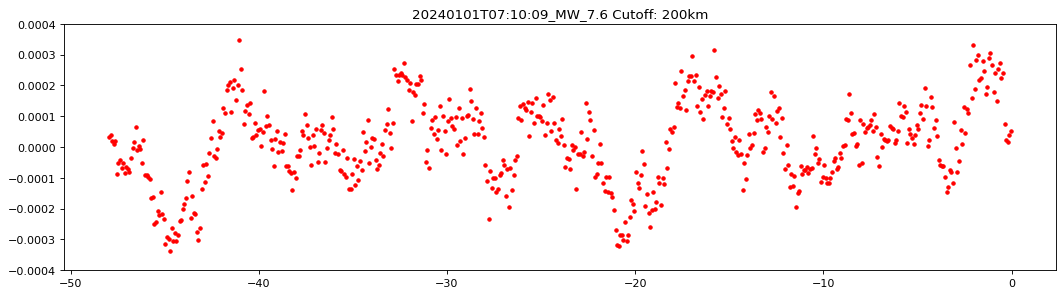

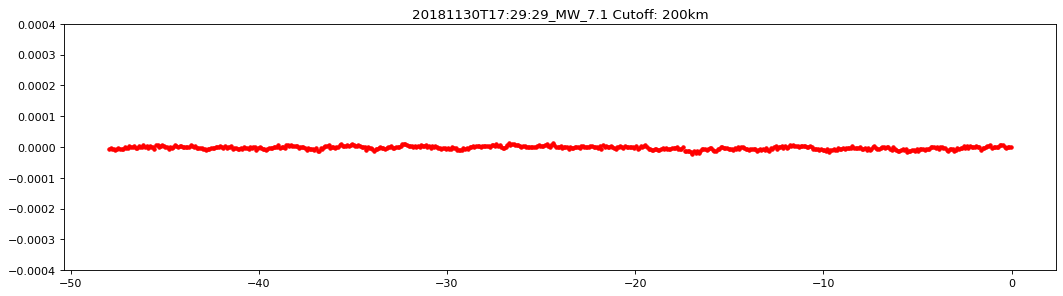

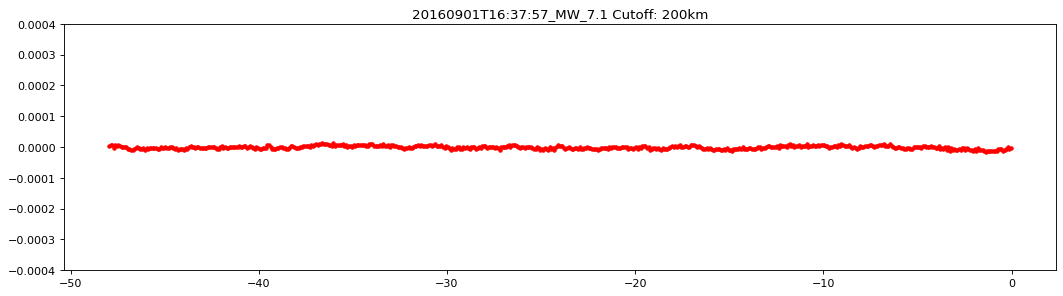

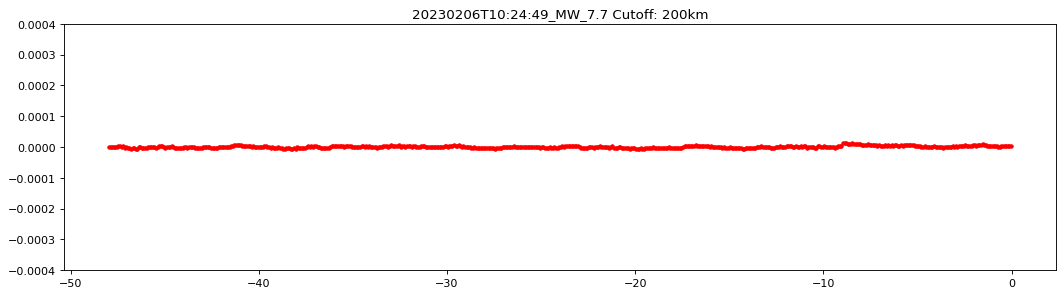

In [22]:
# Plot the stack of the common mode alone (applied to each station) for each event, using a fixed Y scale

for ii in range(len(new_eqlist)):
#     i = np.flip(np.argsort(sg))[ii]
    plt.figure(figsize=(16, 4), dpi=80)
    plt.plot(t,eq_stack_cm[ii,:],'r.')
    plt.ylim([-0.0004,0.0004])
    plt.title(new_eqlist[ii] + ' Cutoff: '+ str(dtcm) + 'km')

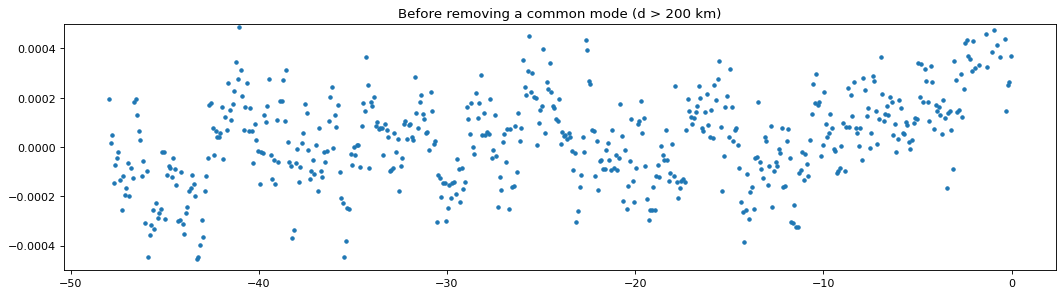

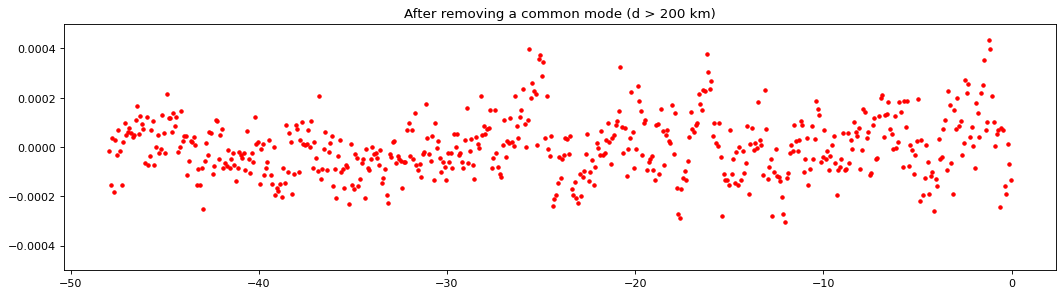

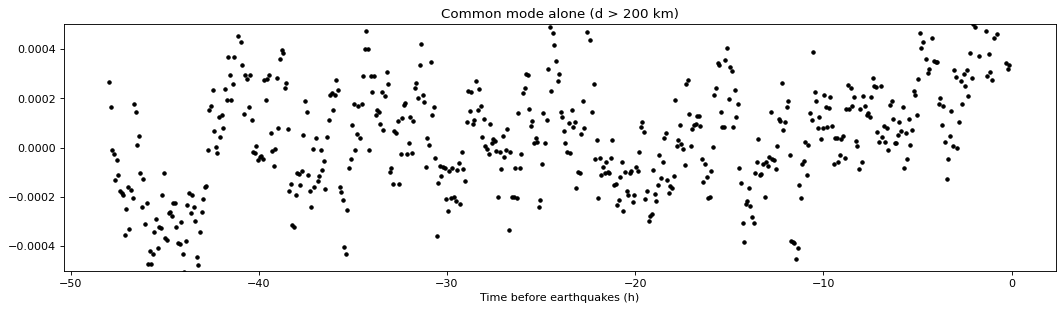

In [23]:
if seltype=='near':
    arr='<'
else:
    arr='>'

plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_o,'.')
plt.title('Before removing a common mode (d {} {} km)'.format(arr, dtcm))
plt.ylim([min([min(stack_o),min(stack),min(stack_cm)])-2e-5,max([max(stack_o),max(stack),max(stack_cm)])+2e-5])
plt.ylim([-0.0005,0.0005])
plt.savefig('Figure_4a.pdf')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack,'.r')
plt.title('After removing a common mode (d {} {} km)'.format(arr, dtcm))
plt.ylim([-0.0005,0.0005])
# plt.ylim([min([min(stack_o),min(stack),min(stack_cm)])-2e-5,max([max(stack_o),max(stack),max(stack_cm)])+2e-5])
plt.savefig('Figure_4b.pdf')
plt.figure(figsize=(16, 4), dpi=80) 
plt.plot(t,stack_cm,'.k')
plt.title('Common mode alone (d {} {} km)'.format(arr, dtcm))
plt.ylim([-0.0005,0.0005])
# plt.ylim([min([min(stack_o),min(stack),min(stack_cm)])-2e-5,max([max(stack_o),max(stack),max(stack_cm)])+2e-5])
plt.xlabel('Time before earthquakes (h)')
plt.savefig('Figure_4c.pdf')

In [56]:
# Calculate Tohoku stack for different source locations (no common mode correction done), no exclusion of nearby sites
# KEB: additionally, calculate the mean value over hour-long intervals. 

# I_TO = np.where(np.array(eq_dir)=='20110311T05:46:24_MW_9.0')[0][0]
t_TO = t[nd:nsample]

# Im = I_TO

eq = '20110311T05:46:24_MW_9.0'
I_eq = int(np.where(np.array(eq_date)==datetime(int(eq[0:4]),int(eq[4:6]),int(eq[6:8]),int(eq[9:11]),int(eq[12:14])))[0])

# Get the list of stations, and their locations
np_code = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=str,usecols=0))
st_lon = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=1))
st_lat = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/station_list.txt',dtype=float,usecols=2))
sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))


lon, lat, dep, strike, dip, rake = 142.37, 38.3, 15, 197, 14, 84

array_gps = np.transpose(np.array([st_lon,st_lat]))
lon_dp, lat_dp = [], []
rmsred_dp, T_dp, dp_2h, = [], [], []
dp_1_2h, dp_1h, dp_2h, dp_3h, dp_4h, dp_5h, dp_6h, dp_7h, dp_8h, dp_9h, dp_10h = [], [], [], [], [], [], [], [], [], [], [] 
dp_11h, dp_12h, dp_13h, dp_14h, dp_15h, dp_16h, dp_17h, dp_18h, dp_19h, dp_20h = [], [], [], [], [], [], [], [], [], [] 
dp_21h, dp_22h, dp_23h, dp_24h = [], [], [], []

allarr = []
bnum=1

for xl in range(-5,2):
    for yl in range(-4,5):
        print('lon: ' + str(lon+xl) + ' lat: ' + str(lon+yl) + ' ' + str(bnum) + '/' + str(7*9))
        lon_dp.append(lon+xl)
        lat_dp.append(lat+yl)
        geometry = np.array([[lon+xl,lat+yl,dep,L,W,L*W,1,strike,dip,0,0,0,0,0,0,0,0,0,0,0,0,0]])
        green = pyeq.green.make.nikkhoo_rde(geometry,array_gps,coor_type='geo',tensile=False,disp=True,strain=False,stress=False,lam=28758000000.0,mu=29353000000.0,verbose=False)
        r_rake = np.radians(rake)
        green_east = np.cos(r_rake)*green[0,:,0,0] + np.sin(r_rake)*green[0,:,0,1]
        green_north = np.cos(r_rake)*green[0,:,1,0] + np.sin(r_rake)*green[0,:,1,1]
        
        i = 0
        dp, sg = np.zeros([len(np_code), nsample]), np.zeros([len(np_code), 1])
        for code in np_code:
            ts = np.genfromtxt(data_byEQ_dir+'/'+eq+'/TS_'+code+'.dat')
            east, north = ts[:,7], ts[:,8]
            east0, north0 = np.median(east[0:nd]), np.median(north[0:nd])
            dp[i,:] = ( (east-east0)*green_east[i] + (north-north0)*green_north[i] ) / sigmaj2[i]
            sg[i] = np.sqrt(green_east[i]*green_east[i] + green_north[i]*green_north[i])
            i = i+1

        # Calculate the stack and divide by the sum of the site GFs - which change depending on EQ location
        # The normalization makes it easier to compare as we move the EQs around
        dp_m = sum(dp)[nd:nsample]/sum(sg) 
               
        # Calculate the mean of the normalized stack over different hour-long windows
        # first is 2 hours to replicate BN23
        
        dp_1_2h.append(np.mean(dp_m[-24:-1]))
        dp_1h.append(np.mean(dp_m[-12:-1]))
        dp_2h.append(np.mean(dp_m[-24:-13]))
        dp_3h.append(np.mean(dp_m[-36:-25]))
        dp_4h.append(np.mean(dp_m[-48:-37]))
        dp_5h.append(np.mean(dp_m[-60:-49]))
        dp_6h.append(np.mean(dp_m[-72:-61]))
        dp_7h.append(np.mean(dp_m[-84:-73]))
        dp_8h.append(np.mean(dp_m[-96:-85]))
        dp_9h.append(np.mean(dp_m[-108:-97]))
        dp_10h.append(np.mean(dp_m[-120:-109]))
        dp_11h.append(np.mean(dp_m[-132:-121]))
        dp_12h.append(np.mean(dp_m[-144:-133]))
        dp_13h.append(np.mean(dp_m[-156:-145]))
        dp_14h.append(np.mean(dp_m[-168:-157]))
        dp_15h.append(np.mean(dp_m[-180:-169]))
        dp_16h.append(np.mean(dp_m[-192:-181]))
        dp_17h.append(np.mean(dp_m[-204:-193]))
        dp_18h.append(np.mean(dp_m[-216:-205]))
        dp_19h.append(np.mean(dp_m[-228:-217]))
        dp_20h.append(np.mean(dp_m[-240:-229]))
        dp_21h.append(np.mean(dp_m[-252:-241]))
        dp_22h.append(np.mean(dp_m[-264:-253]))
        dp_23h.append(np.mean(dp_m[-276:-265]))
        dp_24h.append(np.mean(dp_m[-288:-277]))

        try:
            res = fit_sin(t_TO,dp_m)
            dp_sin = res["fitfunc"](np.array(t_TO)) 
            rmsred_dp.append(100*(np.linalg.norm(dp_m)**2-np.linalg.norm(dp_m-dp_sin)**2)/np.linalg.norm(dp_m)**2)
            T_dp.append(res['period'])
        except:
            rmsred_dp.append(0)
            T_dp.append(0)                                                 
              
        bnum=bnum+1
#         plt.figure(figsize=(16, 4), dpi=80)
#         plt.plot(t_TO,dp_m,'.')
#         plt.xlabel('Time before earthquake (hours)')
#         plt.ylabel('Stack')
#         plt.title('Longitude: '+str(round(lon+xl,2))+' Latitude: '+str(round(lat+yl,2)))
#         plt.close()

lon: 137.37 lat: 138.37 1/63
lon: 137.37 lat: 139.37 2/63
lon: 137.37 lat: 140.37 3/63
lon: 137.37 lat: 141.37 4/63
lon: 137.37 lat: 142.37 5/63
lon: 137.37 lat: 143.37 6/63
lon: 137.37 lat: 144.37 7/63
lon: 137.37 lat: 145.37 8/63
lon: 137.37 lat: 146.37 9/63
lon: 138.37 lat: 138.37 10/63
lon: 138.37 lat: 139.37 11/63
lon: 138.37 lat: 140.37 12/63
lon: 138.37 lat: 141.37 13/63
lon: 138.37 lat: 142.37 14/63
lon: 138.37 lat: 143.37 15/63
lon: 138.37 lat: 144.37 16/63
lon: 138.37 lat: 145.37 17/63
lon: 138.37 lat: 146.37 18/63
lon: 139.37 lat: 138.37 19/63
lon: 139.37 lat: 139.37 20/63
lon: 139.37 lat: 140.37 21/63
lon: 139.37 lat: 141.37 22/63
lon: 139.37 lat: 142.37 23/63
lon: 139.37 lat: 143.37 24/63
lon: 139.37 lat: 144.37 25/63
lon: 139.37 lat: 145.37 26/63
lon: 139.37 lat: 146.37 27/63
lon: 140.37 lat: 138.37 28/63
lon: 140.37 lat: 139.37 29/63
lon: 140.37 lat: 140.37 30/63
lon: 140.37 lat: 141.37 31/63
lon: 140.37 lat: 142.37 32/63
lon: 140.37 lat: 143.37 33/63
lon: 140.37 lat: 14

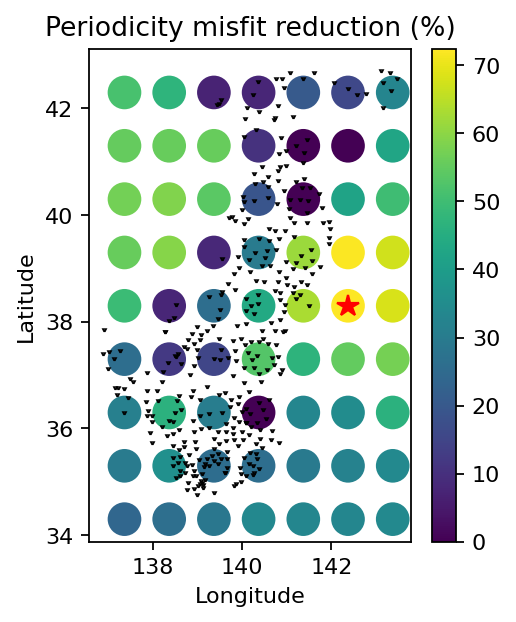

In [39]:
# Plot periodicity (misfit reduction provided best sinusoidal fit) in % for different source locations (Figure S11A)

h =(max(st_lon)-min(st_lon))*np.cos(38*np.pi/180)/(max(st_lat)-min(st_lat))

plt.figure(figsize=(4*h*1.25, 4), dpi=160)
plt.plot(st_lon,st_lat,'vk',markersize=1)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*r',markersize=10)
plt.scatter(lon_dp,lat_dp,200,rmsred_dp)
plt.title('Periodicity misfit reduction (%)')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

0.3223339282112203 0.3223339282112203
Peak is nearby


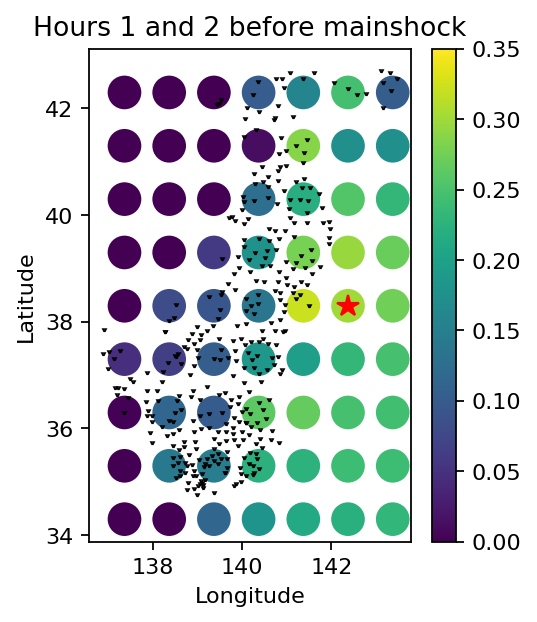

In [40]:
# Plot averaged values in hours 2 and 1 prior for Tohoku stacks calculated considering different source locations (Figure S11B)

plt.figure(figsize=(4*h*1.25, 4), dpi=160)
plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*r',markersize=10)
plt.plot(st_lon,st_lat,'vk',markersize=1)
plt.scatter(lon_dp,lat_dp,200,dp_1_2h, vmin=0, vmax=0.35)
plt.title('Hours 1 and 2 before mainshock')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.savefig(fig_dir+'/hour1_2.tif')

data_arr=dp_1_2h
maxnear=max(data_arr[39],data_arr[40],data_arr[41],data_arr[48],data_arr[49],data_arr[50],data_arr[57],data_arr[58],data_arr[59])
maxall=max(data_arr)
print(maxnear, maxall)
if (maxnear == maxall):
    print("Peak is nearby")
else:
    print("Peak is NOT nearby")

142.37 38.3 0.3102488307850762
141.37 38.3 0.32779937021000977
0.32779937021000977 0.32779937021000977
Peak is nearby
142.37 38.3 0.28630521122732905
141.37 38.3 0.3157939899604948
0.3157939899604948 0.417030650161689
Peak is NOT nearby
142.37 38.3 0.130526018626709
141.37 38.3 0.18337708313440848
0.18337708313440848 0.20926907144075438
Peak is NOT nearby
142.37 38.3 0.06295511406944557
141.37 38.3 0.006412740049844232
0.15527643794159893 0.1714846286065105
Peak is NOT nearby
142.37 38.3 0.21077364572550691
141.37 38.3 0.19566526125696806
0.21882870159873777 0.27584861181271286
Peak is NOT nearby
142.37 38.3 0.14533044834957984
141.37 38.3 0.13170459432070575
0.2205686979705451 0.23575279422315318
Peak is NOT nearby
142.37 38.3 0.026676299334943067
141.37 38.3 0.002948490538537166
0.029619077633290854 0.14221713160994331
Peak is NOT nearby
142.37 38.3 0.0565736057081349
141.37 38.3 -0.026222601825689276
0.07959126943947802 0.07959126943947802
Peak is nearby
142.37 38.3 0.16507021413947

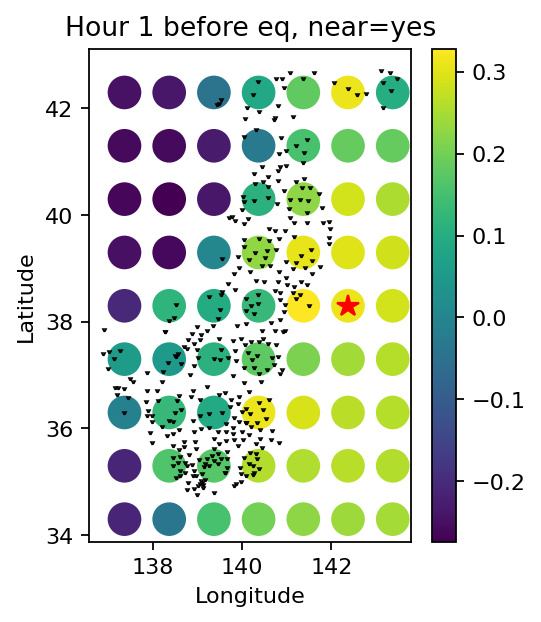

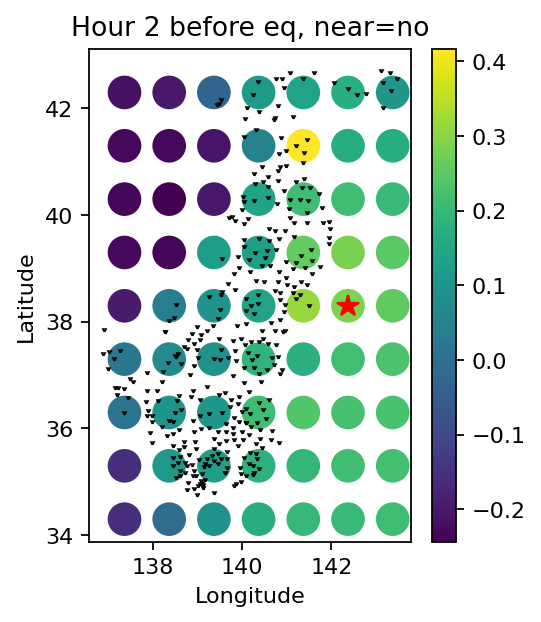

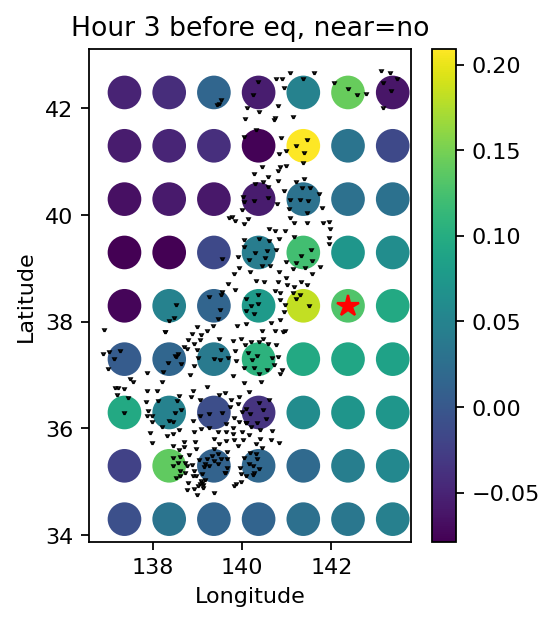

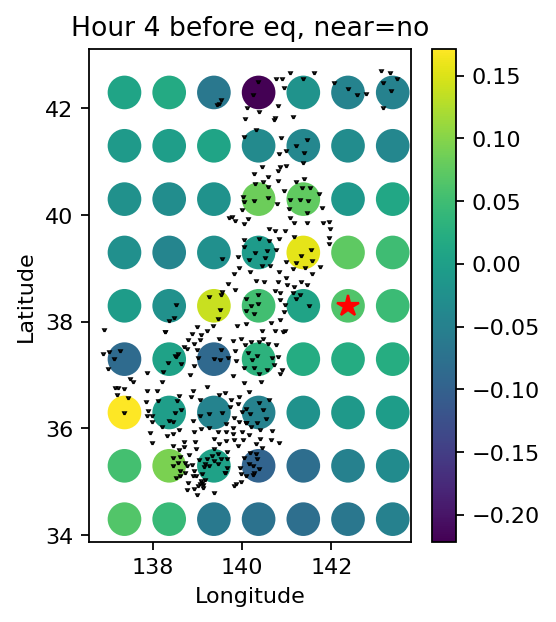

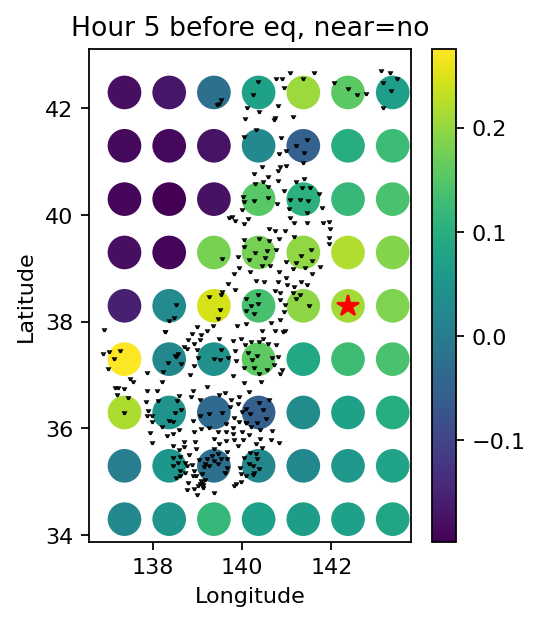

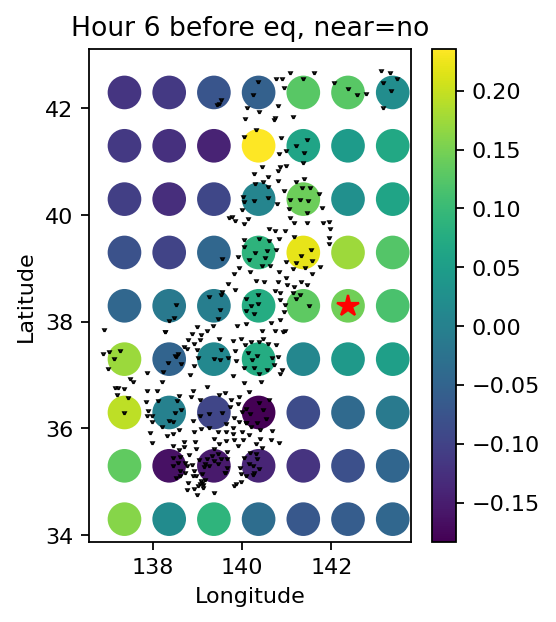

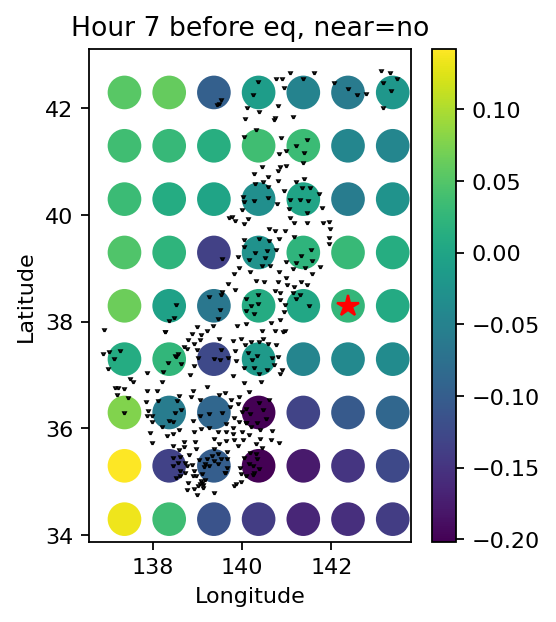

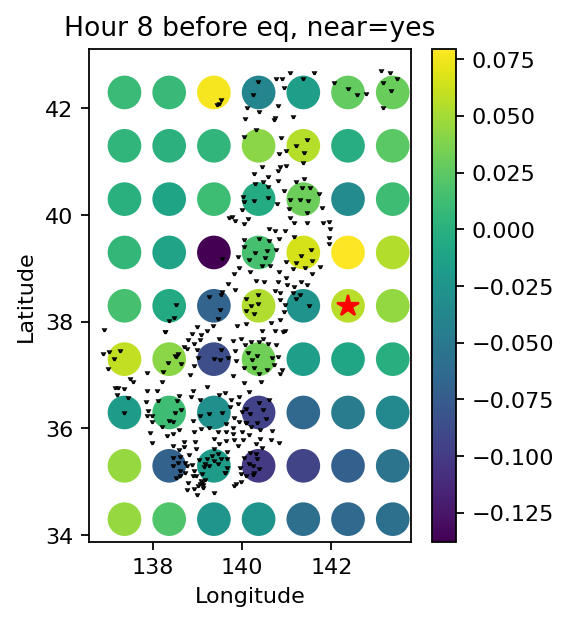

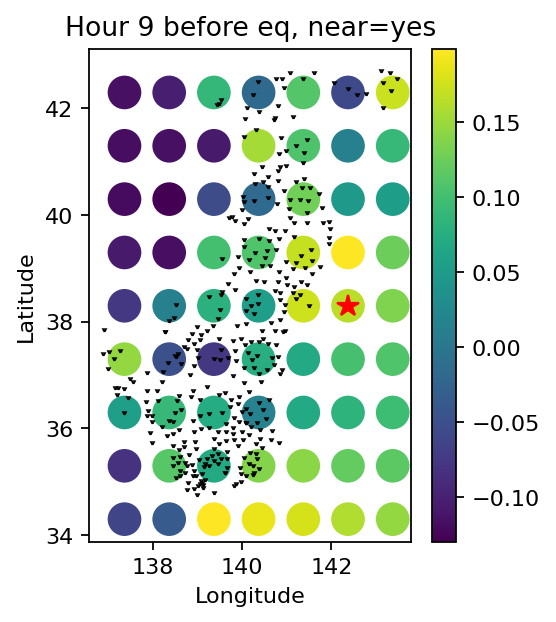

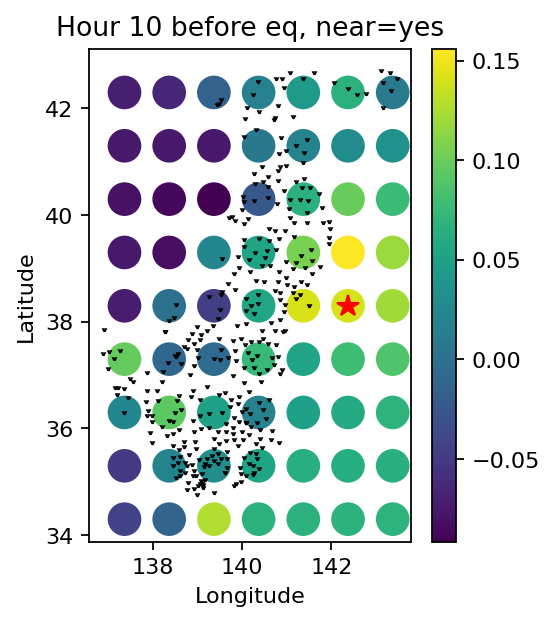

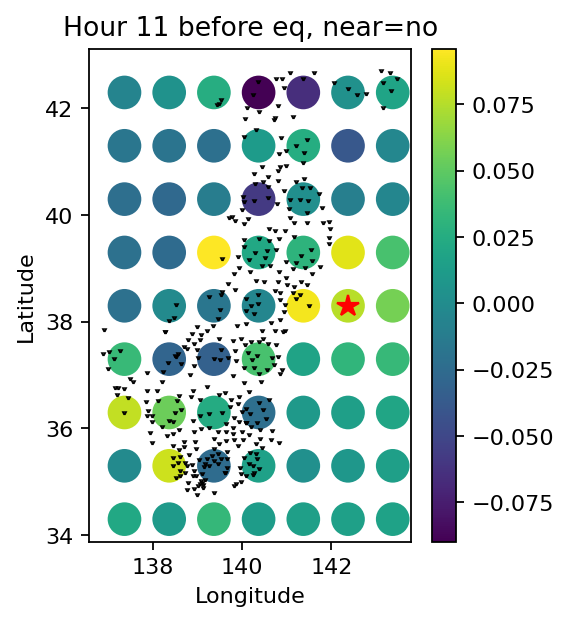

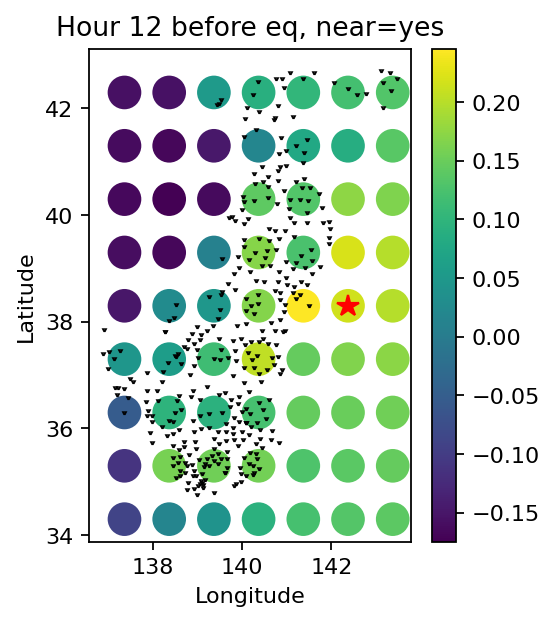

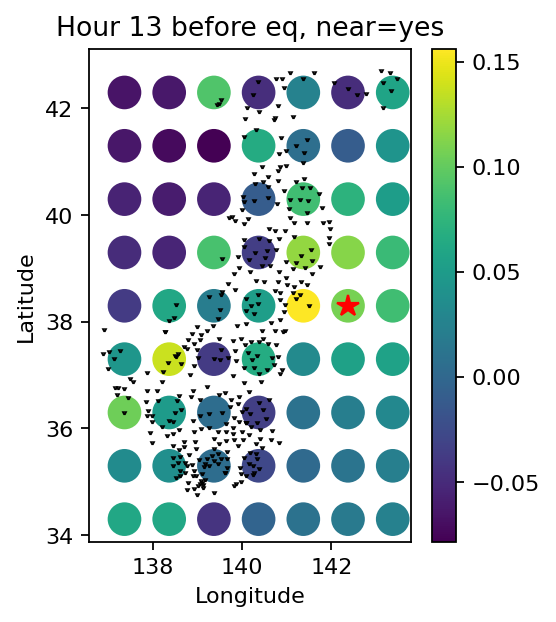

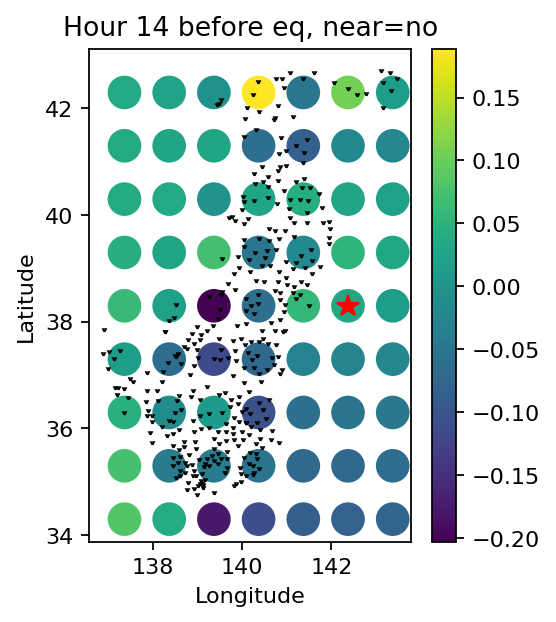

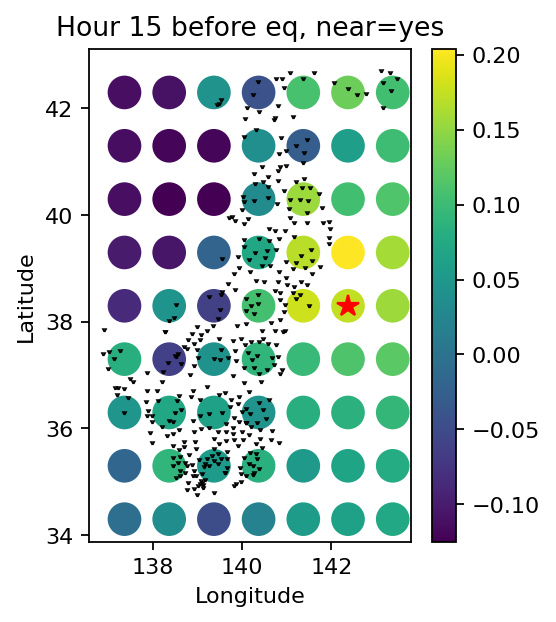

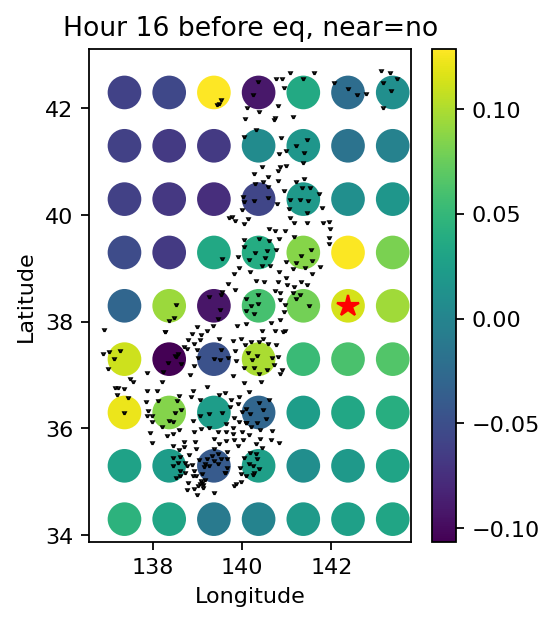

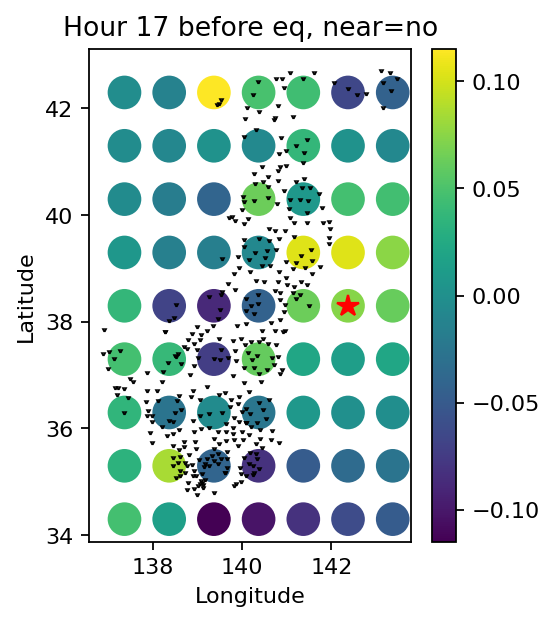

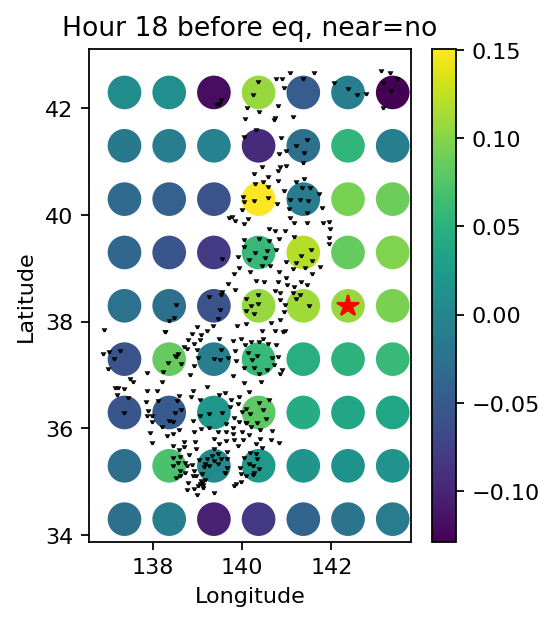

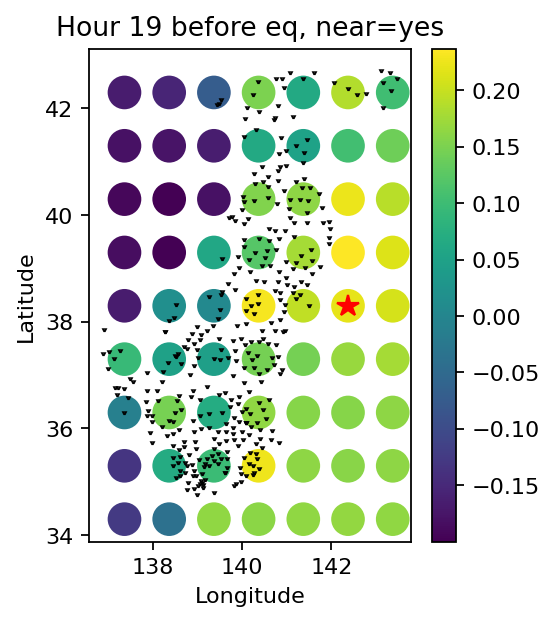

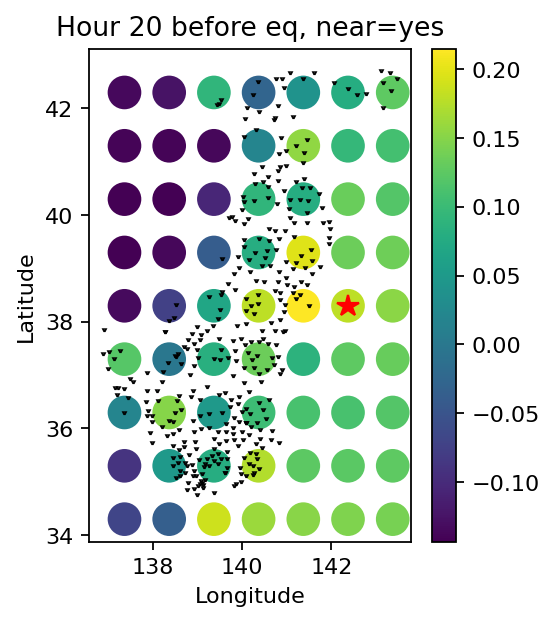

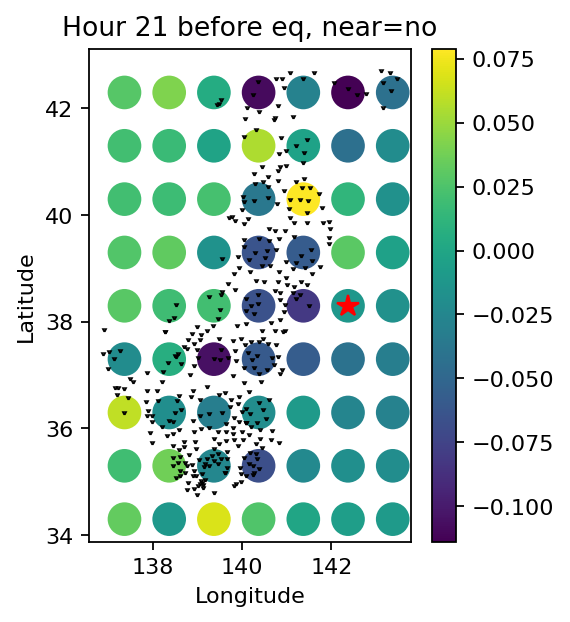

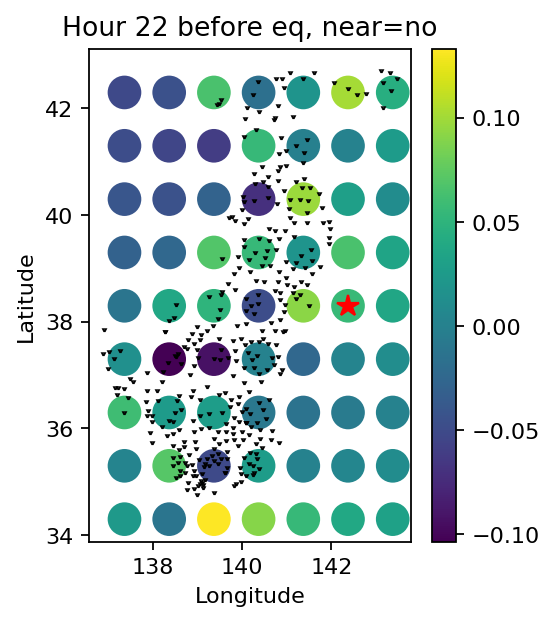

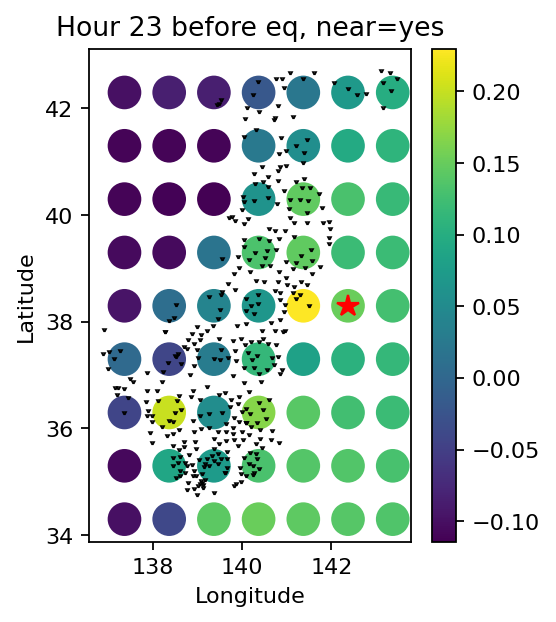

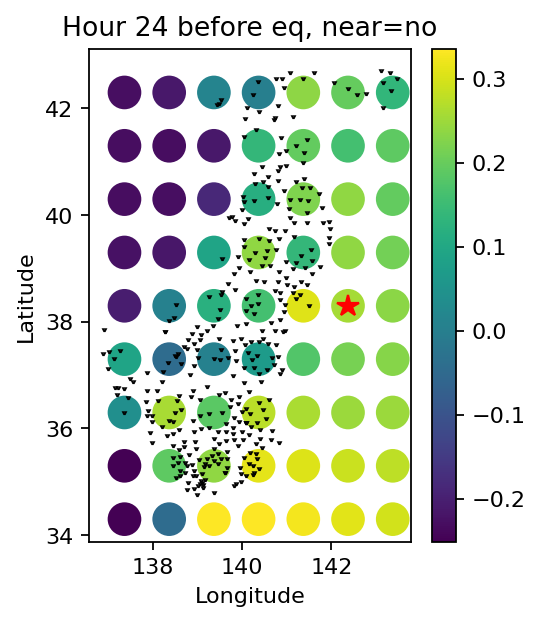

In [28]:
# Plot averaged values over each hour to the Tohoku M9 earthquake
# using stacks calculated considering different source locations

for i in range(1,25):
    key = 'dp_{}h'.format(i)

    plt.figure(figsize=(4*h*1.25, 4), dpi=160)
    plt.plot(eq_lon[I_eq],eq_lat[I_eq],'*r',markersize=10)
    plt.plot(st_lon,st_lat,'vk',markersize=1)
    plt.scatter(lon_dp,lat_dp,200,locals()[key])
    print(lon_dp[49], lat_dp[49], locals()[key][49])
    print(lon_dp[40], lat_dp[40], locals()[key][40])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()

    data_arr=locals()[key]
    maxnear=max(data_arr[39],data_arr[40],data_arr[41],data_arr[48],data_arr[49],data_arr[50],data_arr[57],data_arr[58],data_arr[59])
    maxall=max(data_arr)
    print(maxnear, maxall)
    if (maxnear == maxall):
        print("Peak is nearby")
        peak="yes"
    else:
        print("Peak is NOT nearby")
        peak="no"
    plt.title('Hour {} before eq, near={}'.format(i, peak))


In [16]:
### Re-plot section 4.2 part 2, excluding Japanese megathrust events

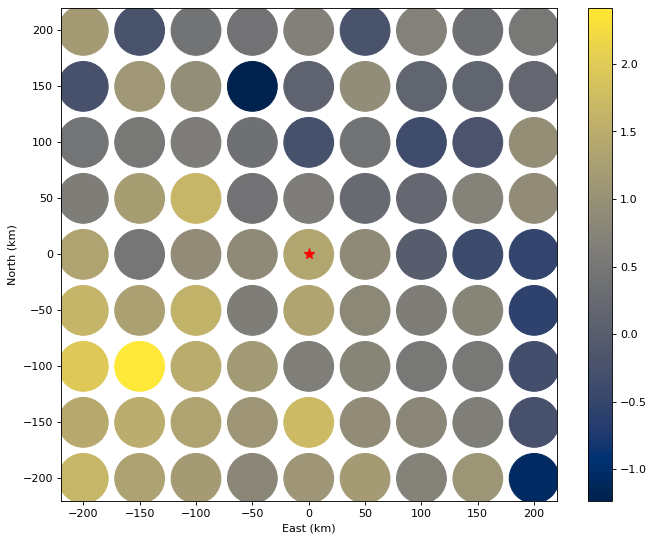

In [46]:

# Variables declaration cell

L, W = 1, 1           # Length and Width of pre-slip areas (same as in Bletery and Nocquet, 2023)
nlon, nlat = 4, 4     # Number of grid points in the east, west, north and south directions 
                      # Total number of grid points will be (2nlon+1)*(2nlat+1)
grid_spacing = 50     # Gird spacing (in km)
nsample = 576         # Number of samples in the time series (48 h, 5-min sampling --> 576 samples)
nd = int(nsample/2)   # Number of samples in 24 h
nr = 36               # Number of rake samples (every 10°)

# Calculate the ratio ratio between the last point of the moving average and its maximum on the [-48,-2] 
# time window 

# KEB: Added option to exclude the Japanese megathrust earthquakes offshore of Honshu

wd = 22                # window duration of the moving average (in samples)
# mynsample=int(nsample/2)
mynsample=int(nsample)

Nsma = mynsample - wd    # number of samples in the moving average time series

N0 = Nsma - 24         # number of samples of the moving average unafected by the last 2 hours
SMA = [0]*Nsma
stack = np.zeros([2*nlon+1,2*nlat+1,nsample])

# Time in hours
t = np.arange(-48-1/24,0-1/24,1/12)
r = np.zeros([2*nlon+1,2*nlat+1])
maxval=0
minval=2

for j in range(2*nlon+1):
    for k in range(2*nlat+1):
        
        eq_stack = []
        
        for eq_file in leq_file:
    
            np_code = np.atleast_1d(np.genfromtxt(eq_file,dtype=str,usecols=0))
            eq = eq_file.split('/')[-2]
            eq_dir = data_byEQ_dir+'/'+eq
            
            if int(eq[0:4]) > 2020:
                continue
            
            # To remove the Japan eastern thrust events, uncomment the following two lines:     
            if eq in ['20110311T05:46:24_MW_9.0','20110407T14:32:43_MW_7.1','20050816T02:46:28_MW_7.2','20110309T02:45:20_MW_7.3']:
                continue
            if eq not in ['20040905T10:07:07_MW_7.2','20040905T14:57:18_MW_7.5','20140403T02:43:13_MW_7.7','20190706T03:19:53_MW_7.0']:
                eq_stack.append(np.genfromtxt(data_byEQ_dir+'/' + eq + '/stack_'+str(j)+'_'+str(k)+'.txt')) 

        stack[j,k,:] = sum(np.array(eq_stack))
        
        for ii in range(Nsma):
            SMA[ii] = np.mean(stack[j,k,ii:ii+wd])
                
        r[j,k] = SMA[-1] / max(SMA[0:N0]) 
        if r[j,k] > maxval:
            maxval = r[j,k]
            SMA_max_saved=SMA.copy()
        if r[j,k] < minval:
            minval = r[j,k]
            SMA_min_saved=SMA.copy()
            

# Plot r for each point of the grid

X, Y = np.zeros([2*nlon+1,2*nlat+1]), np.zeros([2*nlon+1,2*nlat+1])
for j in range(2*nlon+1):
    for k in range(2*nlat+1):
        X[j,k] = grid_spacing * (-nlon + j)
        Y[j,k] = grid_spacing * (-nlat + k)

plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X,Y,2000,c=r,cmap='cividis')
plt.plot(0,0,'*r',markersize=10)
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.colorbar()


excluding 20210320T09:09:43_MW_7.1 : max=0.00016768406613892263
excluding 20100404T22:40:43_MW_7.1 : max=0.00027909923036597146
excluding 20240101T07:10:09_MW_7.6 : max=0.00021734181040593473
107 earthquakes in the stack
3639 stations
Last point with negative stack is 3.17 hours before origin time


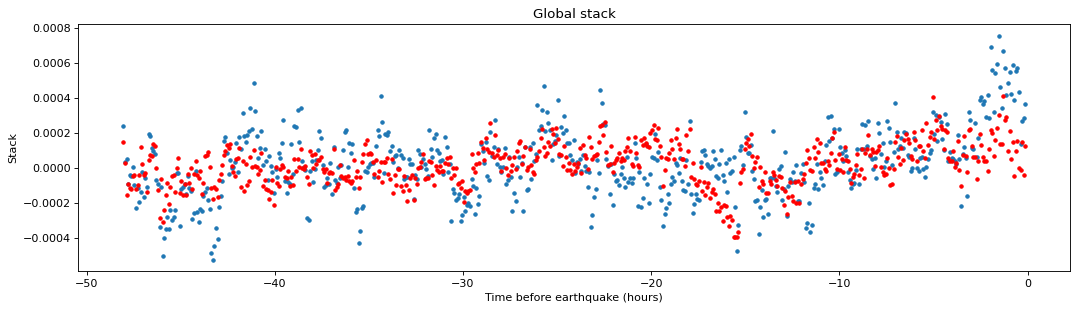

In [50]:
# Find earthquakes with large noise in the 48-24 hours before each earthquake

eq_stack_g, eq_stack_E, eq_stack_N, Nst, sg1, sg2, eq_dir, eq_stack_o  = [], [], [], [], [], [], [], []
this_max = []
for eq_file in leq_file:
    eq = eq_file.split('/')[-2]
# 20110407T14:32:43_MW_7.1 4.2 5.8 4.3 350
# 20140310T05:18:13_MW_7.0 8.8 16.6 6.9 246
# 20110311T05:46:24_MW_9.0 11.5 18.6 5.9 355
# 20210320T09:09:43_MW_7.1 15.4 19.8 10.5 494
# 20100404T22:40:43_MW_7.1 15.1 10.1 12.4 236
# 20110309T02:45:20_MW_7.3 -5.5 -5.6 5.4 327
# 20210213T14:07:49_MW_7.2 9.0 -11.6 7.7 530
# 20240101T07:10:09_MW_7.6 19.7 27.0 14.1 694

#     if eq in ['20110407T14:32:43_MW_7.1','20140310T05:18:13_MW_7.0','20110311T05:46:24_MW_9.0','20210320T09:09:43_MW_7.1','20100404T22:40:43_MW_7.1','20110309T02:45:20_MW_7.3','20210213T14:07:49_MW_7.2','20240101T07:10:09_MW_7.6']:
# #     if eq in ['20100404T22:40:43_MW_7.1','20110311T05:46:24_MW_9.0','20240101T07:10:09_MW_7.6']:
#         plt.figure(figsize=(16, 4), dpi=80)
#         plt.plot(t,np.genfromtxt(eq_file),'.')
#         plt.xlabel('Time before earthquake (hours)')
#         plt.ylim(-0.0005,0.0005)
#         plt.ylabel('Stack')
#         plt.title(eq)
#         continue
    mval=max(abs(np.genfromtxt(eq_file)[0:nd]))
    this_max.append(mval)
    
   
    eq_stack_o.append(np.genfromtxt(eq_file))

    eq_stack_E.append(np.genfromtxt(data_byEQ_dir+'/'+eq+'/dot_product_stack_E.txt'))
    eq_stack_N.append(np.genfromtxt(data_byEQ_dir+'/'+eq+'/dot_product_stack_N.txt'))
    sigmag2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmag2.txt'))
    sigmaj2 = np.atleast_1d(np.genfromtxt(data_byEQ_dir+'/'+eq+'/sigmaj2.txt'))
    
    if mval > 0.00015:
        print('excluding ' + eq + ' : max=' + str(mval))
        continue
        
    eq_stack_g.append(np.genfromtxt(eq_file))

        
    Nst.append(len(sigmag2))
    if len(sigmag2)>1:
        sg1.append(sum(np.divide(np.sqrt(sigmag2),sigmaj2)))   
        sg2.append(sum(np.divide(sigmag2,sigmaj2)))
    else:
        sg1.append(float(np.divide(np.sqrt(sigmag2),sigmaj2)))
        sg2.append(float(np.divide(sigmag2,sigmaj2)))

stack = sum(eq_stack_o)
stack2 = sum(eq_stack_g)
Sg = sum(sg2)
stack_moment = M * stack2 / Sg
stack_E, stack_N = sum(eq_stack_E) * Sg, sum(eq_stack_N) * Sg

print(str(len(eq_stack_g))+' earthquakes in the stack')
print(str(sum(Nst))+' stations')

# Plot the global stack (Figure 2.a)

plt.figure(figsize=(16, 4), dpi=80)
plt.plot(t,stack,'.')
plt.plot(t,stack2,'r.')
plt.xlabel('Time before earthquake (hours)')
plt.ylabel('Stack')
plt.title('Global stack')
plt.savefig(fig_dir+'/Figure_2a.pdf')

I=np.where(stack<0)[0][-1]
tp = t[I]+2.5/60

print('Last point with negative stack is '+str(round(abs(tp),2))+' hours before origin time')
